# Team Based Model

## Imports

In [3]:
import sqlite3
import joblib
import optuna

import pandas as pd
# import plotly.graph_objects as go
# import plotly.express as px

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import cross_val_score

import xgboost as xgb
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
# import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet, LinearRegression, SGDRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pointbiserialr
from sklearn.compose import ColumnTransformer
import seaborn as sns


from sklearn.feature_selection import SequentialFeatureSelector, RFE, RFECV
from tqdm import tqdm
from nba_api.stats.static import players, teams

import sys

%load_ext autoreload
%autoreload 2

sys.path.append("..")

c:\Users\Jordan Nishimura\NBA_Model_v1\nba-model-venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
pd.options.display.max_columns=230
pd.options.display.max_rows=120

## Gather Team Level Basic, Advanced, and Scoring Data

In [34]:
def load_team_data(conn, start_season, end_season):
    """Loads basic, advanced, and scoring boxscores 
    from sqlite db and merges them into one dataframe"""
    

    basic = pd.read_sql("SELECT * FROM team_basic_boxscores", connection)
    adv = pd.read_sql("SELECT * FROM team_advanced_boxscores", connection)
    scoring = pd.read_sql("SELECT * FROM team_scoring_boxscores", connection)
    tracking = pd.read_sql("SELECT * FROM team_tracking_boxscores", connection)

    basic = basic.loc[basic['SEASON'].between(start_season, end_season)]
    basic[['GAME_ID', 'TEAM_ID']] = basic[['GAME_ID', 'TEAM_ID']].astype(str)
    adv[['GAME_ID', 'TEAM_ID']] = adv[['GAME_ID', 'TEAM_ID']].astype(str)
    scoring[['GAME_ID', 'TEAM_ID']] = scoring[['GAME_ID', 'TEAM_ID']].astype(str)
    tracking[['GAME_ID', 'TEAM_ID']] = tracking[['GAME_ID', 'TEAM_ID']].astype(str)

    df = pd.merge(basic, adv, how='left', on=[
                    'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])
    df = pd.merge(df, scoring, how='left', on=[
                  'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])
    
    df = pd.merge(df, tracking, how='left', on=['GAME_ID', 'TEAM_ID'],
                  suffixes=['', '_y'])
    

    df = df.drop(columns=['TEAM_NAME_y', 'TEAM_CITY',
                          'TEAM_ABBREVIATION_y',
                          'TEAM_CITY_y', 'MIN_y',
                          'FG_PCT_y', 'AST_y'])
    
    
    
    return df


start_season = '2013-14'
end_season = '2021-22'

connection = sqlite3.connect('../data/nba.db')
df = load_team_data(connection, start_season, end_season)
connection.close()

In [35]:
def clean_team_data(df):
    """This function cleans the team_data
    1) Changes W/L to 1/0 
    2) Changes franchise abbreviations to their most 
    recent abbreviation for consistency
    3) Converts GAME_DATE to datetime object
    4) Creates a binary column 'HOME_GAME'
    5) Removes 3 games where advanced stats were not collected
    """
    df = df.copy()
    df['WL'] = (df['WL'] == 'W').astype(int)

    abbr_mapping = {'NJN': 'BKN',
                    'CHH': 'CHA',
                    'VAN': 'MEM',
                    'NOH': 'NOP',
                    'NOK': 'NOP',
                    'SEA': 'OKC'}

    df['TEAM_ABBREVIATION'] = df['TEAM_ABBREVIATION'].replace(abbr_mapping)
    df['MATCHUP'] = df['MATCHUP'].str.replace('NJN', 'BKN')
    df['MATCHUP'] = df['MATCHUP'].str.replace('CHH', 'CHA')
    df['MATCHUP'] = df['MATCHUP'].str.replace('VAN', 'MEM')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOH', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOK', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('SEA', 'OKC')

    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

    df['HOME_GAME'] = df['MATCHUP'].str.contains('vs').astype(int)

    return df


clean_df = clean_team_data(df)
clean_df

,SEASON,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,CFG_PCT,UFGM,UFGA,UFG_PCT,DFGM,DFGA,DFG_PCT,HOME_GAME
0,2013-14,1610612746,LAC,Los Angeles Clippers,0021300003,2013-10-29,LAC @ LAL,0,240,41,83,0.494,8,21,0.381,13,23,0.565,10,30,40,27,11,4,16,21,103,-13,103.9,105.1,109.1,117.2,-5.2,-12.1,0.659,1.69,19.8,0.255,0.561,0.423,16.142,16.3,0.542,0.553,1.0,0.200,102.72,98.5,82.08,98,0.497,0.747,0.253,0.641,0.175,0.233,0.184,0.126,0.243,0.466,0.606,0.394,0.875,0.125,0.659,0.341,17.44,40,64,98,394,0,2,279,23,44,0.523,18,39,0.462,12,21,0.571,0
1,2013-14,1610612747,LAL,Los Angeles Lakers,0021300003,2013-10-29,LAL vs. LAC,1,240,42,93,0.452,14,29,0.483,18,28,0.643,18,34,52,23,8,6,19,23,116,13,109.1,117.2,103.9,105.1,5.2,12.1,0.548,1.21,15.6,0.439,0.745,0.577,17.871,19.2,0.527,0.551,1.0,0.195,102.72,98.5,82.08,99,0.503,0.688,0.312,0.483,0.121,0.362,0.112,0.155,0.241,0.362,0.429,0.571,0.786,0.214,0.548,0.452,17.35,44,64,103,449,4,0,318,15,31,0.484,27,62,0.435,20,28,0.714,1
2,2013-14,1610612741,CHI,Chicago Bulls,0021300002,2013-10-29,CHI @ MIA,0,240,35,83,0.422,7,26,0.269,18,23,0.783,11,30,41,23,11,4,19,27,95,-12,93.9,96.9,107.3,108.1,-13.3,-11.1,0.657,1.21,17.0,0.294,NaN,NaN,18.790,19.4,0.464,0.510,1.0,0.198,100.44,98.5,82.08,98,0.401,0.687,0.313,0.589,0.063,0.221,0.179,0.189,0.316,0.526,0.571,0.429,1.000,0.000,0.657,0.343,17.64,37,57,87,446,3,3,317,17,35,0.486,18,48,0.375,11,20,0.550,0
3,2013-14,1610612748,MIA,Miami Heat,0021300002,2013-10-29,MIA vs. CHI,1,240,37,72,0.514,11,20,0.550,22,29,0.759,5,35,40,26,10,7,20,21,107,12,107.3,108.1,93.9,96.9,13.3,11.1,0.703,1.30,19.9,NaN,0.706,NaN,20.048,20.2,0.590,0.631,1.0,0.197,100.44,98.5,82.08,99,0.599,0.722,0.278,0.486,0.168,0.308,0.093,0.206,0.140,0.318,0.577,0.423,1.000,0.000,0.703,0.297,17.01,22,73,93,462,3,3,340,11,28,0.393,26,44,0.591,17,26,0.654,1
4,2013-14,1610612754,IND,Indiana Pacers,0021300001,2013-10-29,IND vs. ORL,1,240,34,71,0.479,7,17,0.412,22,32,0.688,10,34,44,17,4,18,21,13,97,10,101.0,103.2,84.1,92.6,16.8,10.6,0.500,0.81,13.8,0.317,0.617,0.495,21.857,22.3,0.528,0.570,1.0,0.198,99.74,94.0,78.33,94,0.661,0.761,0.239,0.557,0.186,0.216,0.134,0.227,0.299,0.371,0.444,0.556,0.714,0.286,0.500,0.500,16.09,40,78,117,428,1,1,310,20,38,0.526,14,33,0.424,9,21,0.429,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22991,2021-22,1610612738,BOS,Boston Celtics,0042100306,2022-05-27,BOS vs. MIA,0,240,32,72,0.444,11,33,0.333,28,31,0.903,6,28,34,22,10,4,18,28,103,-8,105.5,107.3,114.4,115.6,-8.9,-8.3,0.688,1.22,17.5,0.238,0.667,0.452,18.435,18.8,0.521,0.601,1.0,0.199,97.32,96.0,80.00,96,0.469,0.542,0.458,0.408,0.039,0.320,0.136,0.272,0.223,0.369,0.667,0.333,0.727,0.273,0.688,0.313,16.53,21,52,73,390,1,5,279,14,29,0.483,18,43,0.419,12,20,0.600,1
22992,2021-22,1610612748,MIA,Miami Heat,0042100307,2022-05-29,MIA vs. BOS,0,240,37,88,0.420,6,30,0.200,16,24,0.667,7,37,44,16,4,5,10,18,96,-4,94.5,99.0,101.5,103.1,-6.9,-4.1,0.432,1.60,12.8,0.214,0.741,0.473,9.846,10.3,0.455,0.487,1.0,0.193,100.06,97.0,80.83,97,0.471,0.659,0.341,0.646,0.063,0.188,0.135,0.167,0.135,0.583,0.419,0.581,0.500,0.500,0.432,0.568,17.33,24,58,79,341,0,1,228,22,47,0.468,15,41,0.366,16,27

In [37]:
# from src.data.make_team_dataset import prep_for_aggregation


def prep_for_aggregation(df):
    """This function...
    1) Removes categories that are percentages,
    as we will be averaging them and do not want to average 
    percentages. 
    2) Converts shooting percentage stats into raw values"""
    df = df.copy()

    df = df.drop(columns=['FT_PCT', 'FG_PCT', 'FG3_PCT', 'DREB_PCT',
                          'OREB_PCT', 'REB_PCT', 'AST_PCT', 'AST_TOV',
                          'AST_RATIO', 'E_TM_TOV_PCT', 'TM_TOV_PCT',
                          'EFG_PCT', 'TS_PCT', 'USG_PCT', 'E_USG_PCT',
                          'PACE_PER40', 'MIN', 'PIE', 'CFG_PCT', 'UFG_PCT',
                          'DFG_PCT'])

    df['FG2M'] = df['FGM'] - df['FG3M']
    df['FG2A'] = df['FGA'] - df['FG3A']
    df['PTS_2PT_MR'] = (df['PTS'] * df['PCT_PTS_2PT_MR']).astype('int8')
    df['PTS_FB'] = (df['PTS'] * df['PCT_PTS_FB']).astype('int8')
    df['PTS_OFF_TOV'] = (df['PTS'] * df['PCT_PTS_OFF_TOV']).astype('int8')
    df['PTS_PAINT'] = (df['PTS'] * df['PCT_PTS_PAINT']).astype('int8')
    df['AST_2PM'] = (df['FG2M'] * df['PCT_AST_2PM']).astype('int8')
    df['AST_3PM'] = (df['FG3M'] * df['PCT_AST_3PM']).astype('int8')
    df['UAST_2PM'] = (df['FG2M'] * df['PCT_UAST_2PM']).astype('int8')
    df['UAST_3PM'] = (df['FG3M'] * df['PCT_UAST_3PM']).astype('int8')

    df['POINT_DIFF'] = df['PLUS_MINUS']
    df['RECORD'] = df['WL']
    df['TEAM_SCORE'] = df['PTS']

    return df


clean_df2 = prep_for_aggregation(clean_df)

clean_df2

,SEASON,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,E_PACE,PACE,POSS,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,HOME_GAME,FG2M,FG2A,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,POINT_DIFF,RECORD,TEAM_SCORE
0,2013-14,1610612746,LAC,Los Angeles Clippers,0021300003,2013-10-29,LAC @ LAL,0,41,83,8,21,13,23,10,30,40,27,11,4,16,21,103,-13,103.9,105.1,109.1,117.2,-5.2,-12.1,102.72,98.5,98,0.747,0.253,0.641,0.175,0.233,0.184,0.126,0.243,0.466,0.606,0.394,0.875,0.125,0.659,0.341,17.44,40,64,98,394,0,2,279,23,44,18,39,12,21,0,33,62,18,18,25,47,19,7,13,1,-13,0,103
1,2013-14,1610612747,LAL,Los Angeles Lakers,0021300003,2013-10-29,LAL vs. LAC,1,42,93,14,29,18,28,18,34,52,23,8,6,19,23,116,13,109.1,117.2,103.9,105.1,5.2,12.1,102.72,98.5,99,0.688,0.312,0.483,0.121,0.362,0.112,0.155,0.241,0.362,0.429,0.571,0.786,0.214,0.548,0.452,17.35,44,64,103,449,4,0,318,15,31,27,62,20,28,1,28,64,14,12,27,41,12,11,15,2,13,1,116
2,2013-14,1610612741,CHI,Chicago Bulls,0021300002,2013-10-29,CHI @ MIA,0,35,83,7,26,18,23,11,30,41,23,11,4,19,27,95,-12,93.9,96.9,107.3,108.1,-13.3,-11.1,100.44,98.5,98,0.687,0.313,0.589,0.063,0.221,0.179,0.189,0.316,0.526,0.571,0.429,1.000,0.000,0.657,0.343,17.64,37,57,87,446,3,3,317,17,35,18,48,11,20,0,28,57,5,17,30,49,15,7,12,0,-12,0,95
3,2013-14,1610612748,MIA,Miami Heat,0021300002,2013-10-29,MIA vs. CHI,1,37,72,11,20,22,29,5,35,40,26,10,7,20,21,107,12,107.3,108.1,93.9,96.9,13.3,11.1,100.44,98.5,99,0.722,0.278,0.486,0.168,0.308,0.093,0.206,0.140,0.318,0.577,0.423,1.000,0.000,0.703,0.297,17.01,22,73,93,462,3,3,340,11,28,26,44,17,26,1,26,52,17,9,14,34,15,11,10,0,12,1,107
4,2013-14,1610612754,IND,Indiana Pacers,0021300001,2013-10-29,IND vs. ORL,1,34,71,7,17,22,32,10,34,44,17,4,18,21,13,97,10,101.0,103.2,84.1,92.6,16.8,10.6,99.74,94.0,94,0.761,0.239,0.557,0.186,0.216,0.134,0.227,0.299,0.371,0.444,0.556,0.714,0.286,0.500,0.500,16.09,40,78,117,428,1,1,310,20,38,14,33,9,21,1,27,54,18,12,29,35,11,4,15,2,10,1,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22991,2021-22,1610612738,BOS,Boston Celtics,0042100306,2022-05-27,BOS vs. MIA,0,32,72,11,33,28,31,6,28,34,22,10,4,18,28,103,-8,105.5,107.3,114.4,115.6,-8.9,-8.3,97.32,96.0,96,0.542,0.458,0.408,0.039,0.320,0.136,0.272,0.223,0.369,0.667,0.333,0.727,0.273,0.688,0.313,16.53,21,52,73,390,1,5,279,14,29,18,43,12,20,1,21,39,4,14,22,38,14,7,6,3,-8,0,103
22992,2021-22,1610612748,MIA,Miami Heat,0042100307,2022-05-29,MIA vs. BOS,0,37,88,6,30,16,24,7,37,44,16,4,5,10,18,96,-4,94.5,99.0,101.5,103.1,-6.9,-4.1,100.06,97.0,97,0.659,0.341,0.646,0.063,0.188,0.135,0.167,0.135,0.583,0.419,0.581,0.500,0.500,0.432,0.568,17.33,24,58,79,341,0,1,228,22,47,15,41,16,27,1,31,58,6,12,12,55,12,3,18,3,-4,0,96
22993,2021-22,1610612738,BOS,Boston Celtics,0042100307,2022-05-29,BOS @ MIA,1,35,85,11,32,19,24,10,41,51,22,4,6,13,26,100,4,101.5,103.1,94.5,99.0,6.9,4.1,100.06,97.0,97,0.624,0.376,0.480,0.020,0.330,0.200,0.190,0.140,0.460,0.500,0.500,0.909,0.091,0.629,0.371,16.70,29,71,96,425,3,2,304,19,40,16,45,16,27,0,24,53,2,20,14,46,12,9,12,1,4,1,100
22994,2021-22,1610612744,GSW,Golden State Warriors,0042100401,2022-06-02,GSW vs. BOS,0,39,88,19,45,11,15,12,27,39,24,8,6,14,16,108,-12,111.8,114.9,122.4,129.0,-10.6,-14.1,97.32,93.5,94,0.489,0.511,0.370,0.130,0.528,0.102,0.102,0.093,0.241,0.550,0.450,0.684,0.316,0.615,0.385,16.50,22,43,64,392,3,2,279,16,37,22,49,12,18

## Add Betting Data 

In [7]:
def load_betting_data(conn):
    spreads = pd.read_sql("SELECT * FROM spreads", conn)
    moneylines = pd.read_sql("SELECT * FROM moneylines", conn)

    return spreads, moneylines


connection = sqlite3.connect("../data/nba.db")
spreads, moneylines = load_betting_data(connection)
connection.close()

In [8]:
spreads.loc[(spreads['AWAY_SPREAD']=='') & (spreads['GM_DATE'] >= '2022-01-01')]

,SEASON,GM_DATE,HOME_TEAM,AWAY_TEAM,AWAY_SCOREBOARD,HOME_SCOREBOARD,AWAY_SPREAD,HOME_SPREAD
19599,2021-22,2022-01-25,Washington,L.A. Clippers,"23,13,40,40,116","32,34,27,22,115",,
19600,2021-22,2022-01-25,Detroit,Denver,"34,35,28,13,110","32,27,26,20,105",,
19601,2021-22,2022-01-25,Toronto,Charlotte,"27,34,25,27,113","39,37,29,20,125",,
19602,2021-22,2022-01-25,Philadelphia,New Orleans,"24,34,28,21,107","20,30,36,31,117",,
19603,2021-22,2022-01-25,Brooklyn,L.A. Lakers,"33,29,30,14,106","25,28,25,18,96",,
19604,2021-22,2022-01-25,Boston,Sacramento,"13,17,25,20,75","38,25,34,31,128",,
19605,2021-22,2022-01-25,Houston,San Antonio,"34,32,39,29,134","23,28,23,30,104",,
19606,2021-22,2022-01-25,Golden State,Dallas,"20,31,27,14,92","29,34,34,33,130",,
19607,2021-22,2022-01-25,Portland,Minnesota,"26,29,29,25,109","29,34,19,25,107",,
19608,2021-22,2022-01-27,Philadelphia,L.A. Lakers,"22,26,20,19,87","32,22,34,17,105",,


In [9]:
moneylines

,SEASON,GM_DATE,HOME_TEAM,AWAY_TEAM,AWAY_ML,HOME_ML
0,2020-21,2020-12-22,Brooklyn,Golden State,"+290,+275,+275,-","-360,-330,-350,-"
1,2020-21,2020-12-22,L.A. Lakers,L.A. Clippers,"+110,+110,+120,-","-130,-130,-140,-"
2,2020-21,2020-12-23,Cleveland,Charlotte,"-155,-156,-155,-","+135,+136,+135,-"
3,2020-21,2020-12-23,Indiana,New York,"+270,+300,+265,-","-330,-370,-330,-"
4,2020-21,2020-12-23,Orlando,Miami,"-195,-195,-210,-","+170,+170,+175,-"
...,...,...,...,...,...,...
19843,2021-22,2022-03-06,Oklahoma City,Utah,"-900,-1430,-,-1205","+600,+800,-,+700"
19844,2021-22,2022-03-06,Memphis,Houston,"+525,+400,-,+325","-750,-530,-,-549"
19845,2021-22,2022-03-06,Cleveland,Toronto,"+175,+148,-,+160","-210,-180,-,-182"
19846,2021-22,2022-03-06,Denver,New Orleans,"+150,+125,-,+138","-170,-152,-,-200"


In [10]:
def convert_american_to_decimal(x):
    return np.where(x>0, (100+x)/100, 1+(100.0/-x))                    
                

In [11]:
def clean_moneyline_df(df=moneylines):
    abbr_mapping = {'Boston': 'BOS', 'Portland': 'POR',
                    'L.A. Lakers': 'LAL', 'Brooklyn': 'BKN',
                    'Cleveland': 'CLE', 'Toronto': 'TOR',
                    'Philadelphia': 'PHI', 'Memphis': 'MEM',
                    'Minnesota': 'MIN', 'New Orleans': 'NOP',
                    'Oklahoma City': 'OKC', 'Dallas': 'DAL',
                    'San Antonio': 'SAS', 'Denver': 'DEN',
                    'Golden State': 'GSW', 'L.A. Clippers': 'LAC',
                    'Orlando': 'ORL', 'Utah': 'UTA',
                    'Charlotte': 'CHA', 'Detroit': 'DET',
                    'Miami': 'MIA', 'Phoenix': 'PHX',
                    'Atlanta': 'ATL', 'New York': 'NYK',
                    'Indiana': 'IND', 'Chicago': 'CHI',
                    'Houston': 'HOU', 'Milwaukee': 'MIL',
                    'Sacramento': 'SAC', 'Washington': 'WAS'}

    df['HOME_TEAM'] = df['HOME_TEAM'].replace(abbr_mapping)
    df['AWAY_TEAM'] = df['AWAY_TEAM'].replace(abbr_mapping)

    away_mls = df['AWAY_ML'].str.split(",", expand=True)
    home_mls = df['HOME_ML'].str.split(",", expand=True)

    away_mls = away_mls.replace('-', np.nan).replace('', np.nan)
    away_mls = away_mls.fillna(value=np.nan)
    away_mls = away_mls.astype(float)

    home_mls = home_mls.replace('-', np.nan).replace('', np.nan)
    home_mls = home_mls.fillna(value=np.nan)
    home_mls = home_mls.astype(float)

    highest_away_ml = away_mls.apply(lambda row: np.nanmax(
        abs(row)) if np.nanmax(row) > 0 else -np.nanmax(abs(row)), axis=1)
    highest_away_ml = convert_american_to_decimal(highest_away_ml)
    highest_away_ml = pd.DataFrame(
        highest_away_ml, columns=['HIGHEST_AWAY_ML'])

    highest_home_ml = home_mls.apply(lambda row: np.nanmax(
        abs(row)) if np.nanmax(row) > 0 else -np.nanmax(abs(row)), axis=1)
    highest_home_ml = convert_american_to_decimal(highest_home_ml)
    highest_home_ml = pd.DataFrame(
        highest_home_ml, columns=['HIGHEST_HOME_ML'])

    moneylines = pd.concat(
        [df.iloc[:, :4], highest_home_ml, highest_away_ml], axis=1)

    return moneylines

In [12]:
clean_mls = clean_moneyline_df(df=moneylines)

C:\Users\Jordan Nishimura\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:33: RuntimeWarning: All-NaN axis encountered
C:\Users\Jordan Nishimura\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:39: RuntimeWarning: All-NaN axis encountered


In [13]:
spreads

,SEASON,GM_DATE,HOME_TEAM,AWAY_TEAM,AWAY_SCOREBOARD,HOME_SCOREBOARD,AWAY_SPREAD,HOME_SPREAD
0,2006-07,2006-10-31,Miami,Chicago,"22,37,21,28,108","16,14,21,15,66","-,-,+4½-110,-","-,-,-4½-110,-"
1,2006-07,2006-10-31,L.A. Lakers,Phoenix,"41,17,21,27,106","26,27,34,27,114","-,-,-8½-110,-","-,-,+8½-110,-"
2,2006-07,2006-11-02,Dallas,San Antonio,"26,19,27,25,97","27,24,24,16,91","-,-,+3-110,-","-,-,-3-110,-"
3,2006-07,2006-11-02,L.A. Clippers,Denver,"24,24,22,25,95","18,31,16,31,96","-,-,+4½-110,-","-,-,-4½-110,-"
4,2006-07,2006-11-03,Memphis,Charlotte,"21,26,23,13,83","24,20,16,36,96","-,-,+5-110,-","-,-,-5-110,-"
...,...,...,...,...,...,...,...,...
19845,2021-22,2022-03-06,Oklahoma City,Utah,"33,28,30,25,116","24,21,31,27,103","-13-110,-13½-112,-,-13½-111","+13-110,+13½-110,-,+13½-105"
19846,2021-22,2022-03-06,Memphis,Houston,"27,25,40,31,123","34,28,30,20,112","+11-110,+10½-110,-,+10½-118","-11-110,-10½-110,-,-10½-118"
19847,2021-22,2022-03-06,Cleveland,Toronto,"29,17,16,34,96","30,29,14,31,104","+4½-110,+4½-107,-,+4½-105","-4½-110,-4½-115,-,-4½-118"
19848,2021-22,2022-03-06,Denver,New Orleans,"19,38,37,30,6,130","35,27,22,40,14,138","+4-110,+3½-113,-,+4½-118","-4-110,-3½-109,-,-4½-111"


In [14]:
def clean_spreads_df(df=spreads):
    abbr_mapping = {'Boston': 'BOS', 'Portland': 'POR',
                    'L.A. Lakers': 'LAL', 'Brooklyn': 'BKN',
                    'Cleveland': 'CLE', 'Toronto': 'TOR',
                    'Philadelphia': 'PHI', 'Memphis': 'MEM',
                    'Minnesota': 'MIN', 'New Orleans': 'NOP',
                    'Oklahoma City': 'OKC', 'Dallas': 'DAL',
                    'San Antonio': 'SAS', 'Denver': 'DEN',
                    'Golden State': 'GSW', 'L.A. Clippers': 'LAC',
                    'Orlando': 'ORL', 'Utah': 'UTA',
                    'Charlotte': 'CHA', 'Detroit': 'DET',
                    'Miami': 'MIA', 'Phoenix': 'PHX',
                    'Atlanta': 'ATL', 'New York': 'NYK',
                    'Indiana': 'IND', 'Chicago': 'CHI',
                    'Houston': 'HOU', 'Milwaukee': 'MIL',
                    'Sacramento': 'SAC', 'Washington': 'WAS'}

    df['HOME_TEAM'] = df['HOME_TEAM'].replace(abbr_mapping)
    df['AWAY_TEAM'] = df['AWAY_TEAM'].replace(abbr_mapping)

    away_spreads = df['AWAY_SPREAD'].str.split(",", expand=True)
    home_spreads = df['HOME_SPREAD'].str.split(",", expand=True)

    for col in away_spreads.columns:
        away_spreads[col] = away_spreads[col].str[:-4]
        away_spreads[col] = away_spreads[col].str.replace('½', '.5')
        away_spreads[col] = away_spreads[col].str.replace('PK', '0')

        away_spreads[col] = away_spreads[col].astype(str).apply(
            lambda x: x if x == '' else (x[:-1] if x[-1] == '-' else x))

    away_spreads = away_spreads.replace('-', np.nan)
    away_spreads = away_spreads.replace('', np.nan)
    away_spreads = away_spreads.replace('None', np.nan)
    away_spreads = away_spreads.fillna(value=np.nan)

    away_spreads = away_spreads.astype(float)

    for col in home_spreads.columns:
        home_spreads[col] = home_spreads[col].str[:-4]
        home_spreads[col] = home_spreads[col].str.replace('½', '.5')
        home_spreads[col] = home_spreads[col].str.replace('PK', '0')

        home_spreads[col] = home_spreads[col].astype(str).apply(
            lambda x: x if x == '' else (x[:-1] if x[-1] == '-' else x))

    home_spreads = home_spreads.replace('-', np.nan).replace('', np.nan).replace('None', np.nan)
    home_spreads = home_spreads.fillna(value=np.nan)

    home_spreads = home_spreads.astype(float)

    highest_away_spread = away_spreads.apply(
        lambda row: -np.nanmax(abs(row)) if np.nanmax(row) < 0 else np.nanmax(abs(row)), axis=1)
    highest_away_spread = pd.DataFrame(
        highest_away_spread, columns=['HIGHEST_AWAY_SPREAD'])

    highest_home_spread = home_spreads.apply(
        lambda row: -np.nanmax(abs(row)) if np.nanmax(row) < 0 else np.nanmax(abs(row)), axis=1)
    highest_home_spread = pd.DataFrame(
        highest_home_spread, columns=['HIGHEST_HOME_SPREAD'])

    spreads = pd.concat(
        [df.iloc[:, :4], highest_home_spread, highest_away_spread], axis=1)

    return spreads

In [15]:
clean_spreads = clean_spreads_df(df = spreads)

C:\Users\Jordan Nishimura\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:53: RuntimeWarning: All-NaN axis encountered
C:\Users\Jordan Nishimura\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:58: RuntimeWarning: All-NaN axis encountered


In [16]:
clean_spreads

,SEASON,GM_DATE,HOME_TEAM,AWAY_TEAM,HIGHEST_HOME_SPREAD,HIGHEST_AWAY_SPREAD
0,2006-07,2006-10-31,MIA,CHI,-4.5,4.5
1,2006-07,2006-10-31,LAL,PHX,8.5,-8.5
2,2006-07,2006-11-02,DAL,SAS,-3.0,3.0
3,2006-07,2006-11-02,LAC,DEN,-4.5,4.5
4,2006-07,2006-11-03,MEM,CHA,-5.0,5.0
...,...,...,...,...,...,...
19845,2021-22,2022-03-06,OKC,UTA,13.5,-13.5
19846,2021-22,2022-03-06,MEM,HOU,-11.0,11.0
19847,2021-22,2022-03-06,CLE,TOR,-4.5,4.5
19848,2021-22,2022-03-06,DEN,NOP,-4.5,4.5


In [17]:
clean_mls

,SEASON,GM_DATE,HOME_TEAM,AWAY_TEAM,HIGHEST_HOME_ML,HIGHEST_AWAY_ML
0,2020-21,2020-12-22,BKN,GSW,1.277778,3.900000
1,2020-21,2020-12-22,LAL,LAC,1.714286,2.200000
2,2020-21,2020-12-23,CLE,CHA,2.360000,1.641026
3,2020-21,2020-12-23,IND,NYK,1.270270,4.000000
4,2020-21,2020-12-23,ORL,MIA,2.750000,1.476190
...,...,...,...,...,...,...
19843,2021-22,2022-03-06,OKC,UTA,9.000000,1.069930
19844,2021-22,2022-03-06,MEM,HOU,1.133333,6.250000
19845,2021-22,2022-03-06,CLE,TOR,1.476190,2.750000
19846,2021-22,2022-03-06,DEN,NOP,1.500000,2.500000


In [18]:
def merge_betting_and_boxscore_data(clean_spreads, clean_mls, clean_boxscores):
    clean_boxscores['HOME_TEAM'] = clean_boxscores['MATCHUP'].apply(
        lambda x: x[:3] if 'vs' in x else x[-3:])
    clean_boxscores['AWAY_TEAM'] = clean_boxscores['MATCHUP'].apply(
        lambda x: x[:3] if '@' in x else x[-3:])

    temp = pd.merge(clean_mls, clean_spreads, on=[
                    'SEASON', 'GM_DATE', 'HOME_TEAM', 'AWAY_TEAM'])
    temp['GM_DATE'] = pd.to_datetime(temp['GM_DATE'])

    merged_df = pd.merge(clean_boxscores, temp, how='left', 
                         left_on=['SEASON', 'HOME_TEAM', 'AWAY_TEAM', 'GAME_DATE'],
                         right_on=['SEASON', 'HOME_TEAM', 'AWAY_TEAM', 'GM_DATE'])

    merged_df['ML'] = merged_df.apply(lambda row: row['HIGHEST_HOME_ML'] if row['HOME_GAME'] == 1
                                      else row['HIGHEST_AWAY_ML'], axis=1)

    merged_df['SPREAD'] = merged_df.apply(lambda row: row['HIGHEST_HOME_SPREAD'] if row['HOME_GAME'] == 1
                                          else -row['HIGHEST_HOME_SPREAD'], axis=1)

    merged_df = merged_df.drop(columns=['HOME_TEAM', 'AWAY_TEAM', 'GM_DATE',
                                        'HIGHEST_HOME_ML', 'HIGHEST_AWAY_ML',
                                        'HIGHEST_HOME_SPREAD', 'HIGHEST_AWAY_SPREAD'])

    merged_df['ATS_DIFF'] = merged_df['POINT_DIFF'] + merged_df['SPREAD']

    merged_df['TEAM_COVERED'] = (merged_df['ATS_DIFF'] > 0).astype(int)
    
#     merged_df.loc[merged_df['ATS_DIFF'] == 0.0, 'TEAM_COVERED'] = 0.5

    return merged_df


merged_df = merge_betting_and_boxscore_data(
    clean_spreads, clean_mls, clean_boxscores=clean_df2)

In [19]:
merged_df['ATS_DIFF'].value_counts()

# merged_df.loc[merged_df['TEAM_COVERED']==0.5]

-2.0     787
 2.0     787
 0.0     726
 1.0     721
-1.0     721
        ... 
-43.5      1
 43.5      1
-52.5      1
 52.5      1
 42.5      1
Name: ATS_DIFF, Length: 211, dtype: int64

In [20]:
def normalize_per_100_poss(df):
    df = df.copy(deep=True)
    
    df.iloc[:, 12:27] = 100*df.iloc[:, 12:27].div(df['PACE'], axis=0) 
    df.iloc[:,  35:-4] = 100*df.iloc[:, 35:-4].div(df['PACE'], axis=0) 
    
    return df

stats_per_100 = normalize_per_100_poss(merged_df)
stats_per_100

,SEASON,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,TEAM_SCORE,POINT_DIFF,WL,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,PACE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,ML,SPREAD,ATS_DIFF,TEAM_COVERED
0,2000-01,1610612739,CLE,Cleveland Cavaliers,0020000002,2000-10-31,CLE @ BKN,0,86,4,1,1,30.612245,72.448980,2.040816,7.142857,20.408163,32.653061,11.224490,41.836735,53.061224,16.326531,5.102041,8.163265,19.387755,27.551020,87.755102,4,85.9,87.8,82.5,83.7,3.5,4.1,98.00,23.469388,14.285714,12.244898,36.734694,14.285714,2.040816,15.306122,0.000000,NaN,NaN,NaN,0
1,2000-01,1610612751,BKN,New Jersey Nets,0020000002,2000-10-31,BKN vs. CLE,1,82,-4,0,0,28.571429,76.530612,3.061224,10.204082,17.346939,26.530612,12.244898,35.714286,47.959184,24.489796,9.183673,8.163265,15.306122,31.632653,83.673469,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.00,14.285714,9.183673,20.408163,41.836735,21.428571,3.061224,7.142857,0.000000,NaN,NaN,NaN,0
2,2000-01,1610612745,HOU,Houston Rockets,0020000008,2000-10-31,HOU vs. MIN,1,98,-8,0,0,33.507853,68.062827,2.094241,9.424084,29.319372,41.884817,11.518325,28.272251,39.790576,18.848168,9.424084,7.329843,18.848168,17.801047,102.617801,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.50,15.706806,9.424084,19.895288,50.261780,18.848168,0.000000,14.659686,2.094241,NaN,NaN,NaN,0
3,2000-01,1610612750,MIN,Minnesota Timberwolves,0020000008,2000-10-31,MIN @ HOU,0,106,8,1,1,38.743455,80.628272,6.282723,11.518325,14.659686,16.753927,13.612565,32.460733,46.073298,30.366492,7.329843,1.047120,16.753927,26.178010,110.994764,8,108.1,110.4,99.4,103.2,8.7,7.3,95.50,42.931937,9.424084,23.036649,33.507853,24.083770,6.282723,13.612565,0.000000,NaN,NaN,NaN,0
4,2000-01,1610612759,SAS,San Antonio Spurs,0020000009,2000-10-31,SAS vs. IND,1,98,13,1,1,30.851064,59.574468,4.255319,8.510638,29.787234,37.234043,5.319149,34.042553,39.361702,18.085106,6.382979,4.255319,19.148936,23.404255,104.255319,13,106.1,104.3,90.7,90.4,15.4,13.8,94.00,44.680851,5.319149,14.893617,15.957447,12.765957,4.255319,17.021277,0.000000,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55599,2021-22,1610612740,NOP,New Orleans Pelicans,0022100967,2022-03-06,NOP @ DEN,0,130,-8,0,0,33.670034,67.340067,13.864132,32.679739,19.805902,28.718558,13.864132,34.660329,48.524460,29.708853,8.912656,3.961180,13.864132,29.708853,128.738364,-8,114.3,116.1,124.4,124.3,-10.1,-8.3,100.98,25.747673,10.893246,20.796197,40.602099,18.815607,10.893246,13.864132,1.980590,2.500000,4.5,-3.5,0
55600,2021-22,1610612752,NYK,New York Knicks,0022100966,2022-03-06,NYK @ LAC,0,116,23,1,1,30.208333,62.500000,13.541667,30.208333,19.791667,31.250000,15.625000,43.750000,59.375000,19.791667,4.166667,5.208333,10.416667,18.750000,120.833333,23,119.3,120.8,94.2,96.9,25.1,24.0,96.00,8.333333,12.500000,9.375000,51.041667,10.416667,8.333333,18.750000,4.166667,2.700000,5.5,28.5,1
55601,2021-22,1610612746,LAC,LA Clippers,0022100966,2022-03-06,LAC vs. NYK,1,93,-23,0,0,22.916667,56.250000,11.458333,35.416667,16.666667,22.916667,9.375000,35.416667,44.791667,17.708333,2.083333,5.208333,10.416667,23.958333,96.875000,-23,94.2,96.9,119.3,120.8,-25.1,-24.0,96.00,7.291667,9.375000,17.708333,36.458333,10.416667,6.250000,11.458333,4.166667,1.450450,-5.5,-28.5,0
55602,2021-22,1610612751,BKN,Brooklyn Nets,0022100960,2022-03-06,BKN @ BOS,0,120,-6,0,0,32.835821,61.691542,11.940299,26.865672,17.910448,19.900498,11.940299,32.835821,44.776119,23.880597,5.970149,3.980100,15.920398,25.870647,119.402985,-6,117.9,118.8,126.4,126.0,-8.5,-7.2,100.50,23.880597,5.970149,11.940299,41.791045,15.920398,7.960199,15.920398,2.985075,2.600000,5.5,-0.5,0


In [21]:
def create_matchups(df):
    """This function makes each row a matchup between 
    team and opp"""
    df = df.copy()
    

    matchups = pd.merge(df, df, on=['GAME_ID'], suffixes=['', '_opp'])
    matchups = matchups.loc[matchups['TEAM_ABBREVIATION'] != matchups['TEAM_ABBREVIATION_opp']]

    matchups = matchups.drop(columns = ['SEASON_opp',
                             'TEAM_ABBREVIATION_opp', 'GAME_DATE_opp',
                             'MATCHUP_opp', 'HOME_GAME_opp', 'TEAM_NAME_opp',
                                       'TEAM_ID_opp']
                 )
    
    matchups
    
    return matchups


matchups = create_matchups(stats_per_100)
matchups

,SEASON,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,TEAM_SCORE,POINT_DIFF,WL,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,PACE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,ML,SPREAD,ATS_DIFF,TEAM_COVERED,TEAM_SCORE_opp,POINT_DIFF_opp,WL_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,PACE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,AST_3PM_opp,UAST_2PM_opp,UAST_3PM_opp,ML_opp,SPREAD_opp,ATS_DIFF_opp,TEAM_COVERED_opp
1,2000-01,1610612739,CLE,Cleveland Cavaliers,0020000002,2000-10-31,CLE @ BKN,0,86,4,1,1,30.612245,72.448980,2.040816,7.142857,20.408163,32.653061,11.224490,41.836735,53.061224,16.326531,5.102041,8.163265,19.387755,27.551020,87.755102,4,85.9,87.8,82.5,83.7,3.5,4.1,98.00,23.469388,14.285714,12.244898,36.734694,14.285714,2.040816,15.306122,0.000000,NaN,NaN,NaN,0,82,-4,0,0,28.571429,76.530612,3.061224,10.204082,17.346939,26.530612,12.244898,35.714286,47.959184,24.489796,9.183673,8.163265,15.306122,31.632653,83.673469,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.00,14.285714,9.183673,20.408163,41.836735,21.428571,3.061224,7.142857,0.000000,NaN,NaN,NaN,0
2,2000-01,1610612751,BKN,New Jersey Nets,0020000002,2000-10-31,BKN vs. CLE,1,82,-4,0,0,28.571429,76.530612,3.061224,10.204082,17.346939,26.530612,12.244898,35.714286,47.959184,24.489796,9.183673,8.163265,15.306122,31.632653,83.673469,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.00,14.285714,9.183673,20.408163,41.836735,21.428571,3.061224,7.142857,0.000000,NaN,NaN,NaN,0,86,4,1,1,30.612245,72.448980,2.040816,7.142857,20.408163,32.653061,11.224490,41.836735,53.061224,16.326531,5.102041,8.163265,19.387755,27.551020,87.755102,4,85.9,87.8,82.5,83.7,3.5,4.1,98.00,23.469388,14.285714,12.244898,36.734694,14.285714,2.040816,15.306122,0.000000,NaN,NaN,NaN,0
5,2000-01,1610612745,HOU,Houston Rockets,0020000008,2000-10-31,HOU vs. MIN,1,98,-8,0,0,33.507853,68.062827,2.094241,9.424084,29.319372,41.884817,11.518325,28.272251,39.790576,18.848168,9.424084,7.329843,18.848168,17.801047,102.617801,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.50,15.706806,9.424084,19.895288,50.261780,18.848168,0.000000,14.659686,2.094241,NaN,NaN,NaN,0,106,8,1,1,38.743455,80.628272,6.282723,11.518325,14.659686,16.753927,13.612565,32.460733,46.073298,30.366492,7.329843,1.047120,16.753927,26.178010,110.994764,8,108.1,110.4,99.4,103.2,8.7,7.3,95.50,42.931937,9.424084,23.036649,33.507853,24.083770,6.282723,13.612565,0.000000,NaN,NaN,NaN,0
6,2000-01,1610612750,MIN,Minnesota Timberwolves,0020000008,2000-10-31,MIN @ HOU,0,106,8,1,1,38.743455,80.628272,6.282723,11.518325,14.659686,16.753927,13.612565,32.460733,46.073298,30.366492,7.329843,1.047120,16.753927,26.178010,110.994764,8,108.1,110.4,99.4,103.2,8.7,7.3,95.50,42.931937,9.424084,23.036649,33.507853,24.083770,6.282723,13.612565,0.000000,NaN,NaN,NaN,0,98,-8,0,0,33.507853,68.062827,2.094241,9.424084,29.319372,41.884817,11.518325,28.272251,39.790576,18.848168,9.424084,7.329843,18.848168,17.801047,102.617801,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.50,15.706806,9.424084,19.895288,50.261780,18.848168,0.000000,14.659686,2.094241,NaN,NaN,NaN,0
9,2000-01,1610612759,SAS,San Antonio Spurs,0020000009,2000-10-31,SAS vs. IND,1,98,13,1,1,30.851064,59.574468,4.255319,8.510638,29.787234,37.234043,5.319149,34.042553,39.361702,18.085106,6.382979,4.255319,19.148936,23.404255,104.255319,13,106.1,104.3,90.7,90.4,15.4,13.8,94.00,44.680851,5.319149,14.893617,15.957447,12.765957,4.255319,17.021277,0.000000,NaN,NaN,NaN,0,85,-13,0,0,34.042553,67.021277,4.255319,18.085106,9.574468,13.829787,9.574468,27.659574,37.234043,20.212766,5.319149,4.255319,18.085106,34.042553,90.425532,-13,90.7,90.4,106.1,104.3,-15.4,-13.8,94.00,39.361

In [38]:
# ewma = pd.read_csv('ewma_windows.csv')

# ewma = ewma.loc[ewma['mae'].isin(ewma.groupby('stat')['mae'].min()), ['stat', 'window']]

# ewma_windows_dict = dict(list(zip(ewma['stat'], ewma['window'].astype(int))))
# ewma_windows_dict

{'FG2M': 44,
 'FG2A': 28,
 'FG3M': 28,
 'FG3A': 18,
 'AST': 49,
 'PF': 46,
 'PACE': 24,
 'PTS_2PT_MR': 27,
 'PTS_FB': 34,
 'PTS_PAINT': 39,
 'AST_2PM': 37,
 'AST_3PM': 35,
 'UAST_2PM': 48,
 'UAST_3PM': 49,
 'FTM': 60,
 'FTA': 56,
 'OREB': 60,
 'DREB': 77,
 'REB': 73,
 'STL': 58,
 'BLK': 57,
 'TOV': 64,
 'PTS': 59,
 'PLUS_MINUS': 57,
 'E_OFF_RATING': 53,
 'OFF_RATING': 54,
 'E_DEF_RATING': 73,
 'DEF_RATING': 70,
 'E_NET_RATING': 54,
 'NET_RATING': 60,
 'PTS_OFF_TOV': 81}

In [49]:
matchups

,SEASON,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,TEAM_SCORE,POINT_DIFF,WL,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,PACE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,ML,SPREAD,ATS_DIFF,TEAM_COVERED,TEAM_SCORE_opp,POINT_DIFF_opp,WL_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,PACE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,AST_3PM_opp,UAST_2PM_opp,UAST_3PM_opp,ML_opp,SPREAD_opp,ATS_DIFF_opp,TEAM_COVERED_opp
1,2000-01,1610612739,CLE,Cleveland Cavaliers,0020000002,2000-10-31,CLE @ BKN,0,86,4,1,1,30.612245,72.448980,2.040816,7.142857,20.408163,32.653061,11.224490,41.836735,53.061224,16.326531,5.102041,8.163265,19.387755,27.551020,87.755102,4,85.9,87.8,82.5,83.7,3.5,4.1,98.00,23.469388,14.285714,12.244898,36.734694,14.285714,2.040816,15.306122,0.000000,NaN,NaN,NaN,0,82,-4,0,0,28.571429,76.530612,3.061224,10.204082,17.346939,26.530612,12.244898,35.714286,47.959184,24.489796,9.183673,8.163265,15.306122,31.632653,83.673469,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.00,14.285714,9.183673,20.408163,41.836735,21.428571,3.061224,7.142857,0.000000,NaN,NaN,NaN,0
2,2000-01,1610612751,BKN,New Jersey Nets,0020000002,2000-10-31,BKN vs. CLE,1,82,-4,0,0,28.571429,76.530612,3.061224,10.204082,17.346939,26.530612,12.244898,35.714286,47.959184,24.489796,9.183673,8.163265,15.306122,31.632653,83.673469,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.00,14.285714,9.183673,20.408163,41.836735,21.428571,3.061224,7.142857,0.000000,NaN,NaN,NaN,0,86,4,1,1,30.612245,72.448980,2.040816,7.142857,20.408163,32.653061,11.224490,41.836735,53.061224,16.326531,5.102041,8.163265,19.387755,27.551020,87.755102,4,85.9,87.8,82.5,83.7,3.5,4.1,98.00,23.469388,14.285714,12.244898,36.734694,14.285714,2.040816,15.306122,0.000000,NaN,NaN,NaN,0
5,2000-01,1610612745,HOU,Houston Rockets,0020000008,2000-10-31,HOU vs. MIN,1,98,-8,0,0,33.507853,68.062827,2.094241,9.424084,29.319372,41.884817,11.518325,28.272251,39.790576,18.848168,9.424084,7.329843,18.848168,17.801047,102.617801,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.50,15.706806,9.424084,19.895288,50.261780,18.848168,0.000000,14.659686,2.094241,NaN,NaN,NaN,0,106,8,1,1,38.743455,80.628272,6.282723,11.518325,14.659686,16.753927,13.612565,32.460733,46.073298,30.366492,7.329843,1.047120,16.753927,26.178010,110.994764,8,108.1,110.4,99.4,103.2,8.7,7.3,95.50,42.931937,9.424084,23.036649,33.507853,24.083770,6.282723,13.612565,0.000000,NaN,NaN,NaN,0
6,2000-01,1610612750,MIN,Minnesota Timberwolves,0020000008,2000-10-31,MIN @ HOU,0,106,8,1,1,38.743455,80.628272,6.282723,11.518325,14.659686,16.753927,13.612565,32.460733,46.073298,30.366492,7.329843,1.047120,16.753927,26.178010,110.994764,8,108.1,110.4,99.4,103.2,8.7,7.3,95.50,42.931937,9.424084,23.036649,33.507853,24.083770,6.282723,13.612565,0.000000,NaN,NaN,NaN,0,98,-8,0,0,33.507853,68.062827,2.094241,9.424084,29.319372,41.884817,11.518325,28.272251,39.790576,18.848168,9.424084,7.329843,18.848168,17.801047,102.617801,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.50,15.706806,9.424084,19.895288,50.261780,18.848168,0.000000,14.659686,2.094241,NaN,NaN,NaN,0
9,2000-01,1610612759,SAS,San Antonio Spurs,0020000009,2000-10-31,SAS vs. IND,1,98,13,1,1,30.851064,59.574468,4.255319,8.510638,29.787234,37.234043,5.319149,34.042553,39.361702,18.085106,6.382979,4.255319,19.148936,23.404255,104.255319,13,106.1,104.3,90.7,90.4,15.4,13.8,94.00,44.680851,5.319149,14.893617,15.957447,12.765957,4.255319,17.021277,0.000000,NaN,NaN,NaN,0,85,-13,0,0,34.042553,67.021277,4.255319,18.085106,9.574468,13.829787,9.574468,27.659574,37.234043,20.212766,5.319149,4.255319,18.085106,34.042553,90.425532,-13,90.7,90.4,106.1,104.3,-15.4,-13.8,94.00,39.361

In [51]:
drop_cols = ['TEAM_ID', 'TEAM_NAME', 'GAME_ID', 'MATCHUP', 
             'HOME_GAME', 'TEAM_SCORE', 'ML', 'SPREAD', 
             'ATS_DIFF', 'TEAM_COVERED', 'GAME_DATE', 
             'POINT_DIFF', 'WL', 'RECORD', 'TEAM_SCORE_opp',
            'POINT_DIFF_opp', 'WL_opp', 'ML_opp', 'SPREAD_opp',
            'ATS_DIFF_opp', 'TEAM_COVERED_opp', 'RECORD_opp']

stat_ewmas = []

matchup_info = matchups.iloc[:, :12]
stats = matchups.drop(columns = drop_cols)

for stat in stats.columns[2:]:
    if stat.endswith('_opp'):
        span = ewma_windows_dict[stat[:-4]]
    else:
        span = ewma_windows_dict[stat]

    avg_stats = stats.groupby(['SEASON', 'TEAM_ABBREVIATION'], as_index=True)[stat].apply(lambda x: x.ewm(span=span).mean())
    stat_ewmas.append(avg_stats)

avg_stats = pd.concat(stat_ewmas, axis=1)
avg_stats = pd.concat([matchup_info, avg_stats], axis=1)

avg_stats

,SEASON,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,TEAM_SCORE,POINT_DIFF,WL,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,PACE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,PACE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,AST_3PM_opp,UAST_2PM_opp,UAST_3PM_opp
1,2000-01,1.610613e+09,CLE,Cleveland Cavaliers,0020000002,2000-10-31,CLE @ BKN,0.0,86.0,4.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01,1.610613e+09,BKN,New Jersey Nets,0020000002,2000-10-31,BKN vs. CLE,1.0,82.0,-4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2000-01,1.610613e+09,HOU,Houston Rockets,0020000008,2000-10-31,HOU vs. MIN,1.0,98.0,-8.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2000-01,1.610613e+09,MIN,Minnesota Timberwolves,0020000008,2000-10-31,MIN @ HOU,0.0,106.0,8.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2000-01,1.610613e+09,SAS,San Antonio Spurs,0020000009,2000-10-31,SAS vs. IND,1.0,98.0,13.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(655, 110917)",NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,31.015190,57.905725,11.088067,32.186103,17.455255,22.240989,9.677929,34.462084,44.066760,25.404459,6.716940,4.807879,13.505276,19.546657,111.558366,-3.631341,108.600823,110.428470,111.726166,113.592638,-3.477186,-3.421281,97.318144,10.537008,8.954803,13.557444,50.957823,16.148126,8.954842,14.206878,1.423198,31.447755,60.517219,11.301274,30.917123,18.757194,23.642477,11.278791,34.938112,46.150863,24.674136,7.344411,4.238749,12.282655,20.707927,115.315699,3.631341,112.091311,113.893465,108.398308,110.227950,3.477186,3.421281,97.318144,12.839430,8.023860,14.788228,49.690443,15.404329,8.648564,15.379448,2.146638
"(655, 110953)",NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,30.760937,58.194266,11.135382,31.386442,16.996162,21.611988,9.594840,34.558570,44.095336,25.181896,6.788298,4.913060,13.714097,19.827855,110.807494,-3.724345,107.869232,109.697312,111.242893,113.053510,-3.596384,-3.496309,97.010627,10.934941,9.183174,13.703409,50.024697,15.790904,8.993358,14.288512,1.407714,31.172933,60.623148,11.109318,30.476656,18.857037,23.723010,11.378322,35.053872,46.360423,24.624019,7.432920,4.282287,12.380435,20.248003,114.666828,3.724345,111.479973,113.241220,107.812119,109.618899,3.596384,3.4

In [54]:
stats.groupby(['SEASON', 'TEAM_ABBREVIATION'], as_index=True)['FG3M'].apply(lambda x: x.ewm(span=span).mean())

1          2.040816
2          3.061224
5          2.094241
6          6.282723
9          4.255319
            ...    
111198    10.810011
111201    13.099252
111202    12.491224
111205    11.158220
111206    13.606213
Name: FG3M, Length: 55604, dtype: float64

## Using a teams running average to predict stats

In [22]:
stats_per_100

,SEASON,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,TEAM_SCORE,POINT_DIFF,WL,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,PACE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,ML,SPREAD,ATS_DIFF,TEAM_COVERED
0,2000-01,1610612739,CLE,Cleveland Cavaliers,0020000002,2000-10-31,CLE @ BKN,0,86,4,1,1,30.612245,72.448980,2.040816,7.142857,20.408163,32.653061,11.224490,41.836735,53.061224,16.326531,5.102041,8.163265,19.387755,27.551020,87.755102,4,85.9,87.8,82.5,83.7,3.5,4.1,98.00,23.469388,14.285714,12.244898,36.734694,14.285714,2.040816,15.306122,0.000000,NaN,NaN,NaN,0
1,2000-01,1610612751,BKN,New Jersey Nets,0020000002,2000-10-31,BKN vs. CLE,1,82,-4,0,0,28.571429,76.530612,3.061224,10.204082,17.346939,26.530612,12.244898,35.714286,47.959184,24.489796,9.183673,8.163265,15.306122,31.632653,83.673469,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.00,14.285714,9.183673,20.408163,41.836735,21.428571,3.061224,7.142857,0.000000,NaN,NaN,NaN,0
2,2000-01,1610612745,HOU,Houston Rockets,0020000008,2000-10-31,HOU vs. MIN,1,98,-8,0,0,33.507853,68.062827,2.094241,9.424084,29.319372,41.884817,11.518325,28.272251,39.790576,18.848168,9.424084,7.329843,18.848168,17.801047,102.617801,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.50,15.706806,9.424084,19.895288,50.261780,18.848168,0.000000,14.659686,2.094241,NaN,NaN,NaN,0
3,2000-01,1610612750,MIN,Minnesota Timberwolves,0020000008,2000-10-31,MIN @ HOU,0,106,8,1,1,38.743455,80.628272,6.282723,11.518325,14.659686,16.753927,13.612565,32.460733,46.073298,30.366492,7.329843,1.047120,16.753927,26.178010,110.994764,8,108.1,110.4,99.4,103.2,8.7,7.3,95.50,42.931937,9.424084,23.036649,33.507853,24.083770,6.282723,13.612565,0.000000,NaN,NaN,NaN,0
4,2000-01,1610612759,SAS,San Antonio Spurs,0020000009,2000-10-31,SAS vs. IND,1,98,13,1,1,30.851064,59.574468,4.255319,8.510638,29.787234,37.234043,5.319149,34.042553,39.361702,18.085106,6.382979,4.255319,19.148936,23.404255,104.255319,13,106.1,104.3,90.7,90.4,15.4,13.8,94.00,44.680851,5.319149,14.893617,15.957447,12.765957,4.255319,17.021277,0.000000,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55599,2021-22,1610612740,NOP,New Orleans Pelicans,0022100967,2022-03-06,NOP @ DEN,0,130,-8,0,0,33.670034,67.340067,13.864132,32.679739,19.805902,28.718558,13.864132,34.660329,48.524460,29.708853,8.912656,3.961180,13.864132,29.708853,128.738364,-8,114.3,116.1,124.4,124.3,-10.1,-8.3,100.98,25.747673,10.893246,20.796197,40.602099,18.815607,10.893246,13.864132,1.980590,2.500000,4.5,-3.5,0
55600,2021-22,1610612752,NYK,New York Knicks,0022100966,2022-03-06,NYK @ LAC,0,116,23,1,1,30.208333,62.500000,13.541667,30.208333,19.791667,31.250000,15.625000,43.750000,59.375000,19.791667,4.166667,5.208333,10.416667,18.750000,120.833333,23,119.3,120.8,94.2,96.9,25.1,24.0,96.00,8.333333,12.500000,9.375000,51.041667,10.416667,8.333333,18.750000,4.166667,2.700000,5.5,28.5,1
55601,2021-22,1610612746,LAC,LA Clippers,0022100966,2022-03-06,LAC vs. NYK,1,93,-23,0,0,22.916667,56.250000,11.458333,35.416667,16.666667,22.916667,9.375000,35.416667,44.791667,17.708333,2.083333,5.208333,10.416667,23.958333,96.875000,-23,94.2,96.9,119.3,120.8,-25.1,-24.0,96.00,7.291667,9.375000,17.708333,36.458333,10.416667,6.250000,11.458333,4.166667,1.450450,-5.5,-28.5,0
55602,2021-22,1610612751,BKN,Brooklyn Nets,0022100960,2022-03-06,BKN @ BOS,0,120,-6,0,0,32.835821,61.691542,11.940299,26.865672,17.910448,19.900498,11.940299,32.835821,44.776119,23.880597,5.970149,3.980100,15.920398,25.870647,119.402985,-6,117.9,118.8,126.4,126.0,-8.5,-7.2,100.50,23.880597,5.970149,11.940299,41.791045,15.920398,7.960199,15.920398,2.985075,2.600000,5.5,-0.5,0


In [24]:
def avg_model(df, stat, avg_method='running', n=10):
    matchup_info = df[['SEASON', 'GAME_ID', 'TEAM_ABBREVIATION', 'GAME_DATE', 'HOME_GAME', 'MATCHUP', stat]]

    if avg_method == 'running':
        avg_stats = df.groupby(['TEAM_ABBREVIATION'])[stat].expanding().mean().reset_index()
        
    elif avg_method == 'moving':
        avg_stats = df.groupby(['TEAM_ABBREVIATION'])[stat].rolling(n).mean().reset_index()
        
    elif avg_method == 'ewma':
        avg_stats = df.groupby(['TEAM_ABBREVIATION'])[stat].apply(lambda x: x.ewm(span=n).mean()).reset_index()
        avg_stats['level_1'] = avg_stats['index']
#         avg_stats = pd.concat([df[['SEASON', 'TEAM_ABBREVIATION']], avg_stats], axis=1)
        
    else:
        print("Not a valid avg_method. Enter running, moving, or ewma")
        return None
    
    avg_stats = avg_stats.set_index('level_1')

    avg_stats = pd.merge(matchup_info, avg_stats[stat], left_index=True, right_index=True, suffixes=['_true', '_pred'])

    stat_pred = stat + '_pred'
    stat_true = stat + '_true'
    
    avg_stats = avg_stats.sort_values(['TEAM_ABBREVIATION', 'GAME_DATE'])
    
    avg_stats[stat_pred] = avg_stats.groupby(['TEAM_ABBREVIATION'])[stat_pred].shift(1)

    avg_stats = avg_stats[['SEASON', 'TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'HOME_GAME',
                                  stat_pred, stat_true]]

    avg_stats = avg_stats.dropna()
    
    return avg_stats


In [26]:
df = stats_per_100.loc[stats_per_100['SEASON'] >= '2010-11']
stat='FG3M'

test = avg_model(df, stat, avg_method='ewma', n=10)

np.sqrt(np.mean((test['FG3M_pred'] - test['FG3M_true'])**2))

3.3823592410863963

In [27]:
test

,SEASON,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,FG3M_pred,FG3M_true
25940,2010-11,ATL,0021000021,2010-10-29,ATL @ PHI,0,8.080808,6.382979
25976,2010-11,ATL,0021000031,2010-10-30,ATL vs. WAS,1,7.147002,5.319149
25998,2010-11,ATL,0021000047,2010-11-02,ATL @ CLE,0,6.412217,5.586592
26027,2010-11,ATL,0021000054,2010-11-03,ATL vs. DET,1,6.140211,3.571429
26057,2010-11,ATL,0021000074,2010-11-05,ATL @ MIN,0,5.402783,4.123711
...,...,...,...,...,...,...,...,...
55458,2021-22,WAS,0022100899,2022-02-25,WAS vs. SAS,1,11.587974,15.718636
55476,2021-22,WAS,0022100907,2022-02-26,WAS @ CLE,0,12.339004,11.764706
55516,2021-22,WAS,0022100926,2022-03-01,WAS vs. DET,1,12.234586,13.471503
55563,2021-22,WAS,0022100948,2022-03-04,WAS vs. ATL,1,12.459480,14.814815


In [28]:
def calc_metrics(df, stat, print_result = True):
    stat_pred = stat + '_pred'
    stat_true = stat + '_true'
    mae = mean_absolute_error(df[stat_true], df[stat_pred])
    rmse = mean_squared_error(df[stat_true], df[stat_pred], squared=False)
    if print_result == True:
        print("mean_absolute_error:", mae)
        print("root_mean_squared_error:", rmse)
    
    return mae, rmse
    


In [29]:
running_stats = avg_model(stats_per_100, 'PTS', avg_method='ewma', n=40)    
np.mean((running_stats['PTS_pred'] - running_stats['PTS_true'])**2)**0.5
running_stats['GAME_NUM'] = running_stats.groupby(['TEAM_ABBREVIATION']).cumcount()+1

running_stats

,SEASON,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,PTS_pred,PTS_true,GAME_NUM
48,2000-01,ATL,0020000021,2000-11-02,ATL @ NYK,0,88.648649,78.409091,1
85,2000-01,ATL,0020000036,2000-11-04,ATL vs. ORL,1,83.400875,110.052910,2
107,2000-01,ATL,0020000054,2000-11-06,ATL @ MEM,0,92.732696,86.567164,3
111,2000-01,ATL,0020000060,2000-11-07,ATL @ POR,0,91.073832,92.146597,4
150,2000-01,ATL,0020000077,2000-11-09,ATL @ PHX,0,91.310363,82.291667,5
...,...,...,...,...,...,...,...,...,...
55458,2021-22,WAS,0022100899,2022-02-25,WAS vs. SAS,1,110.209116,150.309461,1814
55476,2021-22,WAS,0022100907,2022-02-26,WAS @ CLE,0,112.165230,91.978610,1815
55516,2021-22,WAS,0022100926,2022-03-01,WAS vs. DET,1,111.180517,120.207254,1816
55563,2021-22,WAS,0022100948,2022-03-04,WAS vs. ATL,1,111.620846,120.634921,1817


In [30]:
atl = running_stats.loc[running_stats['TEAM_ABBREVIATION'] == 'ATL']
sas = running_stats.loc[running_stats['TEAM_ABBREVIATION'] == 'SAS']

<AxesSubplot:xlabel='GAME_NUM'>

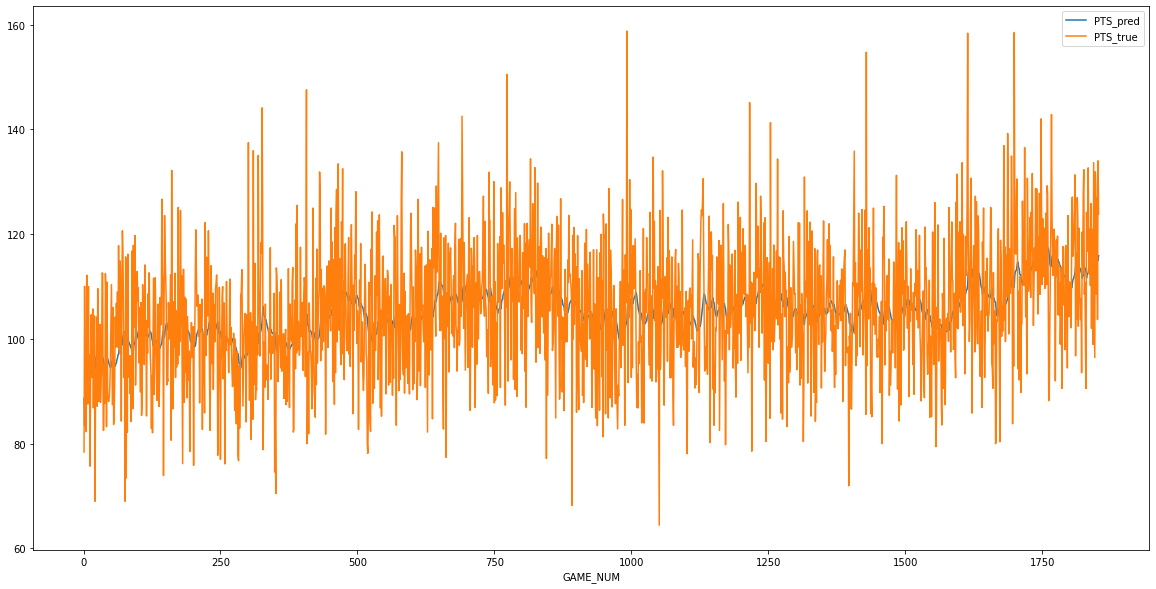

In [31]:
atl[['GAME_NUM', 'PTS_pred', 'PTS_true']].plot(x='GAME_NUM', figsize=(20,10))

In [32]:
stats_per_100.iloc[:, 12:43]

,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,PACE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM
0,30.612245,72.448980,2.040816,7.142857,20.408163,32.653061,11.224490,41.836735,53.061224,16.326531,5.102041,8.163265,19.387755,27.551020,87.755102,4,85.9,87.8,82.5,83.7,3.5,4.1,98.00,23.469388,14.285714,12.244898,36.734694,14.285714,2.040816,15.306122,0.000000
1,28.571429,76.530612,3.061224,10.204082,17.346939,26.530612,12.244898,35.714286,47.959184,24.489796,9.183673,8.163265,15.306122,31.632653,83.673469,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.00,14.285714,9.183673,20.408163,41.836735,21.428571,3.061224,7.142857,0.000000
2,33.507853,68.062827,2.094241,9.424084,29.319372,41.884817,11.518325,28.272251,39.790576,18.848168,9.424084,7.329843,18.848168,17.801047,102.617801,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.50,15.706806,9.424084,19.895288,50.261780,18.848168,0.000000,14.659686,2.094241
3,38.743455,80.628272,6.282723,11.518325,14.659686,16.753927,13.612565,32.460733,46.073298,30.366492,7.329843,1.047120,16.753927,26.178010,110.994764,8,108.1,110.4,99.4,103.2,8.7,7.3,95.50,42.931937,9.424084,23.036649,33.507853,24.083770,6.282723,13.612565,0.000000
4,30.851064,59.574468,4.255319,8.510638,29.787234,37.234043,5.319149,34.042553,39.361702,18.085106,6.382979,4.255319,19.148936,23.404255,104.255319,13,106.1,104.3,90.7,90.4,15.4,13.8,94.00,44.680851,5.319149,14.893617,15.957447,12.765957,4.255319,17.021277,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55599,33.670034,67.340067,13.864132,32.679739,19.805902,28.718558,13.864132,34.660329,48.524460,29.708853,8.912656,3.961180,13.864132,29.708853,128.738364,-8,114.3,116.1,124.4,124.3,-10.1,-8.3,100.98,25.747673,10.893246,20.796197,40.602099,18.815607,10.893246,13.864132,1.980590
55600,30.208333,62.500000,13.541667,30.208333,19.791667,31.250000,15.625000,43.750000,59.375000,19.791667,4.166667,5.208333,10.416667,18.750000,120.833333,23,119.3,120.8,94.2,96.9,25.1,24.0,96.00,8.333333,12.500000,9.375000,51.041667,10.416667,8.333333,18.750000,4.166667
55601,22.916667,56.250000,11.458333,35.416667,16.666667,22.916667,9.375000,35.416667,44.791667,17.708333,2.083333,5.208333,10.416667,23.958333,96.875000,-23,94.2,96.9,119.3,120.8,-25.1,-24.0,96.00,7.291667,9.375000,17.708333,36.458333,10.416667,6.250000,11.458333,4.166667
55602,32.835821,61.691542,11.940299,26.865672,17.910448,19.900498,11.940299,32.835821,44.776119,23.880597,5.970149,3.980100,15.920398,25.870647,119.402985,-6,117.9,118.8,126.4,126.0,-8.5,-7.2,100.50,23.880597,5.970149,11.940299,41.791045,15.920398,7.960199,15.920398,2.985075


In [35]:
stats = []
windows = []
avg_types = []
maes = []
rmses = []

df = stats_per_100.loc[stats_per_100['SEASON']>='2015-16'].copy()

running_stats = avg_model(df, stat, avg_method='running')    
mae, rmse = calc_metrics(running_stats, stat)
stats.append(stat)
windows.append(np.nan)
avg_types.append('running')
maes.append(mae)
rmses.append(rmse)

for stat in tqdm(df.columns[12:43]):
    running_stats = avg_model(df, stat, avg_method='running')    
    mae, rmse = calc_metrics(running_stats, stat, print_result=False)
    stats.append(stat)
    windows.append(np.nan)
    avg_types.append('running')
    maes.append(mae)
    rmses.append(rmse)

    for n in range(10, 83):
        running_stats = avg_model(df, stat, avg_method='moving', n=n)    
        mae, rmse = calc_metrics(running_stats, stat, print_result=False)
        stats.append(stat)
        windows.append(n)
        avg_types.append('moving')
        maes.append(mae)
        rmses.append(rmse)

        running_stats = avg_model(df, stat, avg_method='ewma', n=n)    
        mae, rmse = calc_metrics(running_stats, stat, print_result=False)
        stats.append(stat)
        windows.append(n)
        avg_types.append('ewma')
        maes.append(mae)
        rmses.append(rmse)

result_df = pd.DataFrame({'stat':stats,
                         'window':windows,
                         'avg_type':avg_types,
                         'mae':maes,
                         'rmse':rmses})

result_df.sort_values(['mae'])


mean_absolute_error: 1.1986397937547695
root_mean_squared_error: 1.5789448917109645


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [04:25<00:00,  8.57s/it]


,stat,window,avg_type,mae,rmse
4493,UAST_3PM,50.0,ewma,1.164337,1.500676
4491,UAST_3PM,49.0,ewma,1.164340,1.500611
4495,UAST_3PM,51.0,ewma,1.164340,1.500749
4497,UAST_3PM,52.0,ewma,1.164348,1.500828
4489,UAST_3PM,48.0,ewma,1.164351,1.500554
...,...,...,...,...,...
2945,E_NET_RATING,11.0,ewma,11.795672,14.815656
2944,E_NET_RATING,11.0,moving,11.798902,14.816090
2941,E_NET_RATING,NaN,running,11.825378,14.749115
2943,E_NET_RATING,10.0,ewma,11.839159,14.873156


In [36]:
result_df.to_csv('ewma_windows_2015_22.csv', index=False)
result_df.loc[result_df.groupby(['stat'])['mae'].rank('min') == 1]


,stat,window,avg_type,mae,rmse
61,FG2M,39.0,ewma,3.955219,4.966173
184,FG2A,27.0,ewma,5.996969,7.556270
351,FG3M,37.0,ewma,2.760311,3.483401
464,FG3A,20.0,ewma,4.635688,5.847144
696,FTM,63.0,moving,4.654784,5.792088
857,FTA,70.0,moving,5.574537,6.974353
1024,OREB,80.0,moving,2.965330,3.728196
1171,DREB,80.0,moving,4.132220,5.166872
1308,REB,75.0,moving,5.083554,6.389699
1392,AST,43.0,ewma,3.840125,4.811273


In [55]:
ewma_windows = pd.read_csv('ewma_windows_2015_22.csv')
ewma_windows = ewma_windows.loc[ewma_windows['avg_type'] == 'ewma']
ewma_windows = ewma_windows.loc[ewma_windows.groupby(['stat'])['mae'].rank('min') ==1, ['stat', 'window']]

ewma_windows_dict = dict(list(zip(ewma_windows['stat'], ewma_windows['window'].astype(int))))
ewma_windows_dict

{'FG2M': 39,
 'FG2A': 27,
 'FG3M': 37,
 'FG3A': 20,
 'FTM': 53,
 'FTA': 49,
 'OREB': 53,
 'DREB': 80,
 'REB': 72,
 'AST': 43,
 'STL': 59,
 'BLK': 73,
 'TOV': 70,
 'PF': 50,
 'PTS': 53,
 'PLUS_MINUS': 55,
 'E_OFF_RATING': 50,
 'OFF_RATING': 48,
 'E_DEF_RATING': 77,
 'DEF_RATING': 70,
 'E_NET_RATING': 53,
 'NET_RATING': 57,
 'PACE': 18,
 'PTS_2PT_MR': 21,
 'PTS_FB': 34,
 'PTS_OFF_TOV': 82,
 'PTS_PAINT': 43,
 'AST_2PM': 36,
 'AST_3PM': 44,
 'UAST_2PM': 42,
 'UAST_3PM': 50}

In [62]:
matchups.reset_index(drop=True)

,SEASON,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,TEAM_SCORE,POINT_DIFF,WL,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,PACE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,ML,SPREAD,ATS_DIFF,TEAM_COVERED,TEAM_SCORE_opp,POINT_DIFF_opp,WL_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,PACE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,AST_3PM_opp,UAST_2PM_opp,UAST_3PM_opp,ML_opp,SPREAD_opp,ATS_DIFF_opp,TEAM_COVERED_opp
0,2000-01,1610612739,CLE,Cleveland Cavaliers,0020000002,2000-10-31,CLE @ BKN,0,86,4,1,1,30.612245,72.448980,2.040816,7.142857,20.408163,32.653061,11.224490,41.836735,53.061224,16.326531,5.102041,8.163265,19.387755,27.551020,87.755102,4,85.9,87.8,82.5,83.7,3.5,4.1,98.00,23.469388,14.285714,12.244898,36.734694,14.285714,2.040816,15.306122,0.000000,NaN,NaN,NaN,0,82,-4,0,0,28.571429,76.530612,3.061224,10.204082,17.346939,26.530612,12.244898,35.714286,47.959184,24.489796,9.183673,8.163265,15.306122,31.632653,83.673469,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.00,14.285714,9.183673,20.408163,41.836735,21.428571,3.061224,7.142857,0.000000,NaN,NaN,NaN,0
1,2000-01,1610612751,BKN,New Jersey Nets,0020000002,2000-10-31,BKN vs. CLE,1,82,-4,0,0,28.571429,76.530612,3.061224,10.204082,17.346939,26.530612,12.244898,35.714286,47.959184,24.489796,9.183673,8.163265,15.306122,31.632653,83.673469,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.00,14.285714,9.183673,20.408163,41.836735,21.428571,3.061224,7.142857,0.000000,NaN,NaN,NaN,0,86,4,1,1,30.612245,72.448980,2.040816,7.142857,20.408163,32.653061,11.224490,41.836735,53.061224,16.326531,5.102041,8.163265,19.387755,27.551020,87.755102,4,85.9,87.8,82.5,83.7,3.5,4.1,98.00,23.469388,14.285714,12.244898,36.734694,14.285714,2.040816,15.306122,0.000000,NaN,NaN,NaN,0
2,2000-01,1610612745,HOU,Houston Rockets,0020000008,2000-10-31,HOU vs. MIN,1,98,-8,0,0,33.507853,68.062827,2.094241,9.424084,29.319372,41.884817,11.518325,28.272251,39.790576,18.848168,9.424084,7.329843,18.848168,17.801047,102.617801,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.50,15.706806,9.424084,19.895288,50.261780,18.848168,0.000000,14.659686,2.094241,NaN,NaN,NaN,0,106,8,1,1,38.743455,80.628272,6.282723,11.518325,14.659686,16.753927,13.612565,32.460733,46.073298,30.366492,7.329843,1.047120,16.753927,26.178010,110.994764,8,108.1,110.4,99.4,103.2,8.7,7.3,95.50,42.931937,9.424084,23.036649,33.507853,24.083770,6.282723,13.612565,0.000000,NaN,NaN,NaN,0
3,2000-01,1610612750,MIN,Minnesota Timberwolves,0020000008,2000-10-31,MIN @ HOU,0,106,8,1,1,38.743455,80.628272,6.282723,11.518325,14.659686,16.753927,13.612565,32.460733,46.073298,30.366492,7.329843,1.047120,16.753927,26.178010,110.994764,8,108.1,110.4,99.4,103.2,8.7,7.3,95.50,42.931937,9.424084,23.036649,33.507853,24.083770,6.282723,13.612565,0.000000,NaN,NaN,NaN,0,98,-8,0,0,33.507853,68.062827,2.094241,9.424084,29.319372,41.884817,11.518325,28.272251,39.790576,18.848168,9.424084,7.329843,18.848168,17.801047,102.617801,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.50,15.706806,9.424084,19.895288,50.261780,18.848168,0.000000,14.659686,2.094241,NaN,NaN,NaN,0
4,2000-01,1610612759,SAS,San Antonio Spurs,0020000009,2000-10-31,SAS vs. IND,1,98,13,1,1,30.851064,59.574468,4.255319,8.510638,29.787234,37.234043,5.319149,34.042553,39.361702,18.085106,6.382979,4.255319,19.148936,23.404255,104.255319,13,106.1,104.3,90.7,90.4,15.4,13.8,94.00,44.680851,5.319149,14.893617,15.957447,12.765957,4.255319,17.021277,0.000000,NaN,NaN,NaN,0,85,-13,0,0,34.042553,67.021277,4.255319,18.085106,9.574468,13.829787,9.574468,27.659574,37.234043,20.212766,5.319149,4.255319,18.085106,34.042553,90.425532,-13,90.7,90.4,106.1,104.3,-15.4,-13.8,94.00,39.361

In [88]:
stat='RECORD'

df = matchups.copy()

df = df.sort_values(['GAME_DATE', 'GAME_ID', 'HOME_GAME']).reset_index(drop=True)

ewma_windows = pd.read_csv('ewma_windows_2015_22.csv')

drop_cols = ['TEAM_ID', 'TEAM_NAME', 'GAME_ID', 'MATCHUP', 
             'HOME_GAME', 'TEAM_SCORE', 'ML', 'SPREAD', 
             'ATS_DIFF', 'TEAM_COVERED', 'GAME_DATE', 
             'POINT_DIFF', 'WL', 'TEAM_SCORE_opp',
            'POINT_DIFF_opp', 'WL_opp', 'ML_opp', 'SPREAD_opp',
            'ATS_DIFF_opp', 'TEAM_COVERED_opp']

stats = df.drop(columns=drop_cols)

stats.groupby(['TEAM_ABBREVIATION'])[stat].transform(lambda x: x.ewm(span=span).mean()).reset_index()


,index,RECORD
0,0,1.000000
1,1,0.000000
2,2,1.000000
3,3,0.000000
4,4,0.000000
...,...,...
55599,55599,0.293893
55600,55600,0.312250
55601,55601,0.558292
55602,55602,0.516260


In [137]:
test['RECORD'].ewm(span=19).mean().head(20)

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.175583
8     0.146920
9     0.124363
10    0.106239
11    0.230793
12    0.199848
13    0.173935
14    0.277959
15    0.243841
16    0.334591
17    0.295223
18    0.261090
19    0.231368
Name: RECORD, dtype: float64

In [131]:
test = matchups.sort_values(['TEAM_ABBREVIATION', 'GAME_DATE']).reset_index(drop=True)

test.groupby('TEAM_ABBREVIATION')['RECORD'].apply(lambda x: x.ewm(span=19).mean()).head(20)



0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.175583
8     0.146920
9     0.124363
10    0.106239
11    0.230793
12    0.199848
13    0.173935
14    0.277959
15    0.243841
16    0.334591
17    0.295223
18    0.261090
19    0.231368
Name: RECORD, dtype: float64

In [130]:
test.groupby('TEAM_ABBREVIATION')['RECORD'].ewm(span=19).mean().reset_index().head(20)

,TEAM_ABBREVIATION,level_1,RECORD
0,ATL,0,0.000000
1,ATL,1,0.000000
2,ATL,2,0.000000
3,ATL,3,0.000000
4,ATL,4,0.000000
5,ATL,5,0.000000
6,ATL,6,0.000000
7,ATL,7,0.175583
8,ATL,8,0.146920
9,ATL,9,0.124363


In [138]:
ewma_windows = pd.read_csv('ewma_windows_2015_22.csv')

def build_team_avg_stats_df(df: pd.DataFrame, ewma_windows: pd.DataFrame) -> pd.DataFrame:    
    """This function finds the average for each team and opp statistic up to (and NOT including) the given date.
    """
    
    df = df.copy()

    df = df.sort_values(['TEAM_ABBREVIATION', 'GAME_DATE']).reset_index(drop=True)

    ewma_windows = pd.read_csv('ewma_windows_2015_22.csv')

    drop_cols = ['TEAM_ID', 'TEAM_NAME', 'GAME_ID', 'MATCHUP', 
                 'HOME_GAME', 'TEAM_SCORE', 'ML', 'SPREAD', 
                 'ATS_DIFF', 'TEAM_COVERED', 'GAME_DATE', 
                 'POINT_DIFF', 'WL', 'TEAM_SCORE_opp',
                'POINT_DIFF_opp', 'WL_opp', 'ML_opp', 'SPREAD_opp',
                'ATS_DIFF_opp', 'TEAM_COVERED_opp']

    stats = df.drop(columns=drop_cols)

    ewma_windows = ewma_windows.loc[ewma_windows['avg_type'] == 'ewma']
    ewma_windows = ewma_windows.loc[ewma_windows.groupby(['stat'])['mae'].rank('min') ==1, ['stat', 'window']]

    ewma_windows_dict = dict(list(zip(ewma_windows['stat'], ewma_windows['window'].astype(int))))
    ewma_windows_dict

    avg_stat_holder = []

    for stat in stats.columns[2:]:
        if stat.endswith('_opp'):
            try:
                span = ewma_windows_dict[stat[:-4]]
            except KeyError:
                span = 19
        else:
            try:
                span = ewma_windows_dict[stat]
            except KeyError:
                span = 19

        avg_stats = stats.groupby(['TEAM_ABBREVIATION'])[stat].ewm(span=span).mean().reset_index(drop=True)
        avg_stat_holder.append(avg_stats)


    matchup_info = df[['SEASON', 'TEAM_ABBREVIATION', 'GAME_DATE',
                          'GAME_ID', 'MATCHUP', 'HOME_GAME', 'TEAM_SCORE',
                          'ML', 'SPREAD', 'ATS_DIFF', 'TEAM_COVERED', 
                          'POINT_DIFF', 'WL', 'RECORD']]   

    avg_stats = pd.concat(avg_stat_holder, axis=1)
    avg_stats = pd.concat([matchup_info, avg_stats], axis=1)
    
    avg_stats = avg_stats.sort_values(['TEAM_ABBREVIATION', 'GAME_DATE'])
    avg_stats.iloc[:, 14:] = avg_stats.iloc[:, 14:].shift(1).where(avg_stats['TEAM_ABBREVIATION'].eq(avg_stats['TEAM_ABBREVIATION'].shift()))

    return avg_stats

team_stats_ewa = build_team_avg_stats_df(matchups, ewma_windows)

team_stats_ewa.loc[team_stats_ewa['TEAM_ABBREVIATION'] == 'SAS'].sort_values('GAME_DATE')



,SEASON,TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_GAME,TEAM_SCORE,ML,SPREAD,ATS_DIFF,TEAM_COVERED,POINT_DIFF,WL,RECORD,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,PACE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,PACE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,AST_3PM_opp,UAST_2PM_opp,UAST_3PM_opp
48062,2000-01,SAS,2000-10-31,0020000009,SAS vs. IND,1,98,NaN,NaN,NaN,0,13,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48063,2000-01,SAS,2000-11-02,0020000024,SAS vs. MIN,1,103,NaN,NaN,NaN,0,12,1,1,1.000000,30.851064,59.574468,4.255319,8.510638,29.787234,37.234043,5.319149,34.042553,39.361702,18.085106,6.382979,4.255319,19.148936,23.404255,104.255319,13.000000,106.100000,104.300000,90.700000,90.400000,15.400000,13.800000,94.000000,44.680851,5.319149,14.893617,15.957447,12.765957,4.255319,17.021277,0.000000,0.000000,34.042553,67.021277,4.255319,18.085106,9.574468,13.829787,9.574468,27.659574,37.234043,20.212766,5.319149,4.255319,18.085106,34.042553,90.425532,-13.000000,90.700000,90.400000,106.100000,104.300000,-15.400000,-13.800000,94.000000,39.361702,9.574468,23.404255,27.659574,15.957447,4.255319,17.021277,0.000000
48064,2000-01,SAS,2000-11-04,0020000045,SAS @ GSW,0,117,NaN,NaN,NaN,0,12,1,1,1.000000,33.063254,66.860641,4.327358,9.811784,29.727679,35.056997,8.767387,34.054390,42.804942,18.952374,5.372449,4.326423,18.911787,23.237316,108.805326,12.490909,106.610000,108.230208,93.992208,95.826429,12.547170,12.273684,92.416667,37.393812,11.631125,16.254412,28.033397,14.111657,4.327056,18.433593,0.000000,0.000000,38.562856,79.562951,2.634456,10.898118,10.295084,15.183731,12.534354,26.452245,38.970478,21.678149,6.525840,5.997354,16.715572,31.252280,95.303091,-12.490909,94.015000,95.861458,106.606494,108.205000,-12.547170,-12.273684,92.416667,44.646336,10.302542,15.452477,31.499475,19.051353,2.641242,18.433593,0.000000
48065,2000-01,SAS,2000-11-07,0020000059,SAS @ PHX,0,81,NaN,NaN,NaN,0,-19,0,0,1.000000,33.391649,68.343848,5.266816,10.248090,29.129920,36.078306,10.923806,35.402609,46.298124,20.713766,4.554677,5.242141,18.256232,21.768011,111.640597,12.321287,109.935369,111.276103,97.517765,98.972063,12.323256,12.179237,95.230216,31.035349,9.289491,14.118555,34.651880,15.128407,5.258836,17.932797,0.000000,0.000000,37.664396,82.944416,4.168985,12.771498,10.884967,17.549177,15.463379,25.956011,41.379038,21.790460,7.378672,6.340767,13.384084,28.044017,98.658120,-12.321287,97.581362,99.035426,109.887745,111.220822,-12.323256,-12.179237,95.230216,39.292238,11.255089,15.980950,35.163681,17.977221,3.114901,18.631455,0.693508
48066,2000-01,SAS,2000-11-08,0020000068,SAS vs. LAL,1,91,NaN,NaN,NaN,0,10,1,1,0.709218,32.662832,69.939357,4.127858,9.733515,27.024330,33.804191,11.113170,33.630244,44.712524,20.267729,4.470072,5.805904,19.566616,21.046574,104.787611,4.058775,102.155749,104.609937,98.838249,100.622483,3.277176,3.943131,95.016175,30.632200,9.930012,14.299039,33.590681,15.617344,4.136016,16.529282,0.000000,0.290782,39.206725,80.474582,3.613504,13.055886,11.364307,17.666065,13.893400,27.458244,41.350591,24.172338,9.611436,6.342965,14.309229,27.903254,100.551216,-4.058775,98.912285,100.700784,102.278101,104.695020,-3.277176,-3.943131,95.016175,37.128049,13.378384,18.147425,40.481062,20.850456,2.848004,17.324346,0.509592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [147]:
def build_league_avg_stats_df(df):
    """This function finds the league average for each statistic per season up to (and NOT including) the given date.
    """
    df = df.copy()
    
    df = df.drop(columns=['TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'MATCHUP', 'HOME_GAME', 'TEAM_SCORE', 'ML', 'SPREAD', 'ATS_DIFF', 'TEAM_COVERED',
       'POINT_DIFF', 'WL', 'RECORD'])

    grouped_df = df.groupby(['SEASON', 'GAME_DATE']).agg(['sum', 'count']).reset_index()
    grouped_df_cum = grouped_df.groupby(['SEASON']).cumsum().reset_index(drop=True)

    cum_stats_per_date = {}
    cum_stats_per_date['SEASON'] = grouped_df['SEASON']
    cum_stats_per_date['GAME_DATE'] = grouped_df['GAME_DATE']
    
    for col in grouped_df_cum.columns.get_level_values(0):
        avg = grouped_df_cum[col]['sum'] / grouped_df_cum[col]['count']
        
        cum_stats_per_date[col] = avg
        
    cum_stats_per_date = pd.DataFrame(cum_stats_per_date).sort_values('GAME_DATE')
    cum_stats_per_date.iloc[:, 2:] = cum_stats_per_date.iloc[:, 2:].shift(1)
    
    cum_stats_per_date = cum_stats_per_date.add_suffix('_LA')
    
    cum_stats_per_date = cum_stats_per_date.rename(columns={'SEASON_LA':'SEASON', 'GAME_DATE_LA':'GAME_DATE'})
        
    return cum_stats_per_date
    

league_avg_stats = build_league_avg_stats_df(stats_per_100)
league_avg_stats

C:\Users\Jordan Nishimura\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,SEASON,GAME_DATE,FG2M_LA,FG2A_LA,FG3M_LA,FG3A_LA,FTM_LA,FTA_LA,OREB_LA,DREB_LA,REB_LA,AST_LA,STL_LA,BLK_LA,TOV_LA,PF_LA,PTS_LA,PLUS_MINUS_LA,E_OFF_RATING_LA,OFF_RATING_LA,E_DEF_RATING_LA,DEF_RATING_LA,E_NET_RATING_LA,NET_RATING_LA,PACE_LA,PTS_2PT_MR_LA,PTS_FB_LA,PTS_OFF_TOV_LA,PTS_PAINT_LA,AST_2PM_LA,AST_3PM_LA,UAST_2PM_LA,UAST_3PM_LA
0,2000-01,2000-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01,2000-11-01,31.555637,68.891512,4.919231,13.380559,20.050208,28.302749,11.849749,32.089327,43.939075,22.472790,8.483969,5.632116,18.058562,26.751870,97.919176,0.0,97.065385,97.911538,97.065385,97.911538,0.0,0.0,95.346154,24.289412,12.521626,19.681598,37.779459,17.763408,4.227429,13.066985,0.489505
2,2000-01,2000-11-02,32.035344,69.519005,4.763330,13.516074,20.999455,29.150165,12.204569,31.592315,43.796884,22.272067,8.549595,5.828185,18.801209,27.260082,99.360131,0.0,97.057500,98.342500,97.057500,98.342500,0.0,0.0,95.078500,23.446448,12.458482,20.097841,39.582381,17.645088,4.078420,13.626711,0.499245
3,2000-01,2000-11-03,32.085703,69.493949,4.970785,13.900412,21.051177,28.535669,12.258558,31.171158,43.429716,22.369042,8.198034,5.900695,18.602248,27.100860,100.134939,0.0,97.944444,99.383333,97.944444,99.383333,0.0,0.0,94.391481,23.979350,12.202917,19.110841,39.119472,17.577043,4.303638,13.721334,0.468749
4,2000-01,2000-11-04,31.462838,69.529329,4.804118,13.727273,21.189110,28.581012,12.452740,31.542183,43.994923,21.803483,8.543007,6.046586,18.773927,27.163994,98.527140,0.0,96.492424,97.913636,96.492424,97.913636,0.0,0.0,94.441515,23.834363,12.461039,19.175855,38.067407,17.232547,4.125324,13.442267,0.483579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4424,2021-22,2022-03-02,28.355954,53.684385,12.476742,35.689744,16.746102,21.698613,10.539125,34.803366,45.342492,24.646532,7.732338,4.870342,14.086719,19.796752,110.888234,0.0,108.281715,110.274002,108.281715,110.274002,0.0,0.0,98.697994,8.849863,11.876895,15.822728,46.903584,14.035815,9.850932,13.536175,2.011514
4425,2021-22,2022-03-03,28.350467,53.659944,12.485404,35.693552,16.761177,21.719552,10.523249,34.814128,45.337377,24.650983,7.746394,4.863826,14.094454,19.810374,110.918323,0.0,108.297754,110.284813,108.297754,110.284813,0.0,0.0,98.712791,8.836415,11.893223,15.849736,46.907851,14.033716,9.855486,13.531504,2.015551
4426,2021-22,2022-03-04,28.371507,53.674885,12.494724,35.683386,16.763868,21.721300,10.521402,34.782206,45.303608,24.671367,7.740785,4.858810,14.081001,19.814508,110.991053,0.0,108.375584,110.362155,108.375584,110.362155,0.0,0.0,98.692633,8.845881,11.895230,15.858219,46.939801,14.043581,9.864965,13.540758,2.015494
4427,2021-22,2022-03-05,28.372566,53.685585,12.495203,35.671792,16.777677,21.739997,10.527959,34.773834,45.301793,24.676881,7.731357,4.858884,14.073844,19.818737,111.008418,0.0,108.399264,110.385910,108.399264,110.385910,0.0,0.0,98.701325,8.855811,11.895538,15.856530,46.932111,14.046734,9.865048,13.538728,2.015938


In [151]:
team_stats_ewa.iloc[:, 46:78]

,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,PACE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,AST_3PM_opp,UAST_2PM_opp,UAST_3PM_opp
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.000000,32.432432,57.297297,5.405405,9.729730,33.513514,43.243243,7.567568,40.000000,47.567568,17.297297,7.567568,6.486486,18.378378,24.864865,114.594595,24.000000,118.300000,114.000000,88.900000,89.100000,29.400000,24.800000,92.500000,19.459459,6.486486,14.054054,44.324324,12.972973,3.243243,18.378378,2.162162
2,1.000000,31.534682,59.994995,6.714423,12.377303,27.439734,33.355689,4.870196,39.309659,44.192090,21.238215,6.030900,6.078641,16.549798,24.354238,110.633026,24.509091,112.282000,110.325000,83.784416,83.673571,28.584906,26.631579,90.125000,18.194981,3.732747,16.718216,43.158391,15.649741,4.490242,14.787499,1.639005
3,1.000000,32.721694,60.868885,5.842111,13.272343,28.563541,34.633225,8.677057,34.917219,43.553402,18.996740,5.775862,6.171311,18.857742,24.348824,111.530691,17.077126,112.253566,111.531925,91.895817,92.529501,20.320978,18.959540,91.748201,20.440844,9.888213,18.959184,43.607165,14.610819,3.662728,17.015005,1.804544
4,1.000000,31.947828,64.145517,4.530367,11.164313,29.955824,37.854643,10.065636,34.377196,44.390366,19.238681,7.134657,5.600793,17.832122,23.696899,107.562299,15.210190,108.022746,107.668796,90.493857,90.852592,17.540015,16.837391,94.313526,20.856607,13.158588,19.976982,42.055483,15.505705,2.949657,15.387505,1.325986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55599,0.583768,30.684212,59.424964,11.477324,31.299411,18.280823,23.071709,10.987859,34.745302,45.591165,24.270750,7.455856,4.449462,12.432449,20.732038,113.873114,3.383200,111.535079,113.338831,108.150923,110.032735,3.348329,3.137483,96.741378,12.450253,8.086320,14.775632,48.503336,14.812676,8.698032,15.131457,2.165726
55600,0.625391,31.507797,60.513433,11.338609,31.031851,18.840871,23.838594,11.163073,34.712137,45.687866,24.730467,7.403811,4.408861,12.552691,20.766590,115.368151,3.405228,112.090566,113.965818,108.552182,110.409277,3.294687,3.212053,97.272812,13.193931,8.073348,14.987736,49.558469,15.392681,8.704419,15.387237,2.080796
55601,0.662852,31.215829,60.621908,11.192163,30.622910,18.935297,23.911788,11.264579,34.805730,45.871936,24.675873,7.477872,4.434232,12.620876,20.371633,114.739542,3.497899,111.510544,113.310070,108.099562,109.904791,3.409699,3.287499,96.875674,12.286170,7.978706,15.219331,49.396235,15.312198,8.697829,15.169002,1.999196
55602,0.596567,31.468509,60.954984,11.039426,30.371135,18.963216,23.908685,11.384697,34.688350,45.835981,24.637615,7.539491,4.398410,12.615647,20.426144,114.826909,3.265831,111.655228,113.489251,108.412393,110.177895,3.094525,3.108620,96.836129,12.205514,8.470227,15.426918,49.835831,15.324730,8.679711,15.379240,1.920796


In [157]:
temp = pd.merge(team_stats_ewa, league_avg_stats, how='left', on=['GAME_DATE', 'SEASON'], suffixes=['', '_LA'])
matchup_info = temp.iloc[:, :14]
team_stats_normalized = temp.iloc[:, 15:46] - temp.iloc[:, 78:].values
opp_stats_normalized = temp.iloc[:, 47:78] - temp.iloc[:, 78:].values

stats_normalized = pd.concat([matchup_info, team_stats_normalized, opp_stats_normalized], axis=1)

stats_normalized

,SEASON,TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_GAME,TEAM_SCORE,ML,SPREAD,ATS_DIFF,TEAM_COVERED,POINT_DIFF,WL,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,PACE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,PACE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,AST_3PM_opp,UAST_2PM_opp,UAST_3PM_opp
0,2000-01,ATL,2000-10-31,0020000004,ATL vs. CHA,1,82,NaN,NaN,NaN,0,-24,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01,ATL,2000-11-02,0020000021,ATL @ NYK,0,69,NaN,NaN,NaN,0,-25,0,0,-6.089398,1.832347,1.723157,2.700142,-3.702157,-6.447462,-0.312677,-12.132856,-12.445533,-7.136931,1.180134,-3.666023,-4.747155,6.253432,-10.711482,-24.000000,-8.157500,-9.242500,21.242500,15.657500,-29.400000,-24.800000,-2.578500,-14.797800,-2.728752,1.523781,3.660862,-10.077520,2.408067,3.670586,-0.499245,0.397089,-12.221707,0.642076,-3.786344,12.514059,14.093078,-4.637001,8.407685,3.770683,-4.974769,-0.982028,0.658302,-0.422830,-2.395217,15.234464,24.000000,21.242500,15.657500,-8.157500,-9.242500,29.400000,24.800000,-2.578500,-3.986989,-5.971996,-6.043787,4.741943,-4.672115,-0.835176,4.751667,1.662917
2,2000-01,ATL,2000-11-04,0020000036,ATL vs. ORL,1,104,NaN,NaN,NaN,0,-3,0,0,-6.001993,1.946238,0.685622,2.924294,-5.177914,-8.764661,1.485649,-6.976688,-5.494036,-2.783998,-0.293726,-4.404349,-2.050208,1.428082,-15.094869,-24.509091,-12.743424,-14.275095,15.830952,12.434935,-28.584906,-26.631579,-4.316515,-9.001673,-5.399686,-6.196440,-1.832335,-4.794398,1.368589,-1.509278,-0.483579,0.071843,-9.534334,1.910305,-1.349969,6.250624,4.774676,-7.582544,7.767476,0.197167,-0.565268,-2.512107,0.032055,-2.224129,-2.809756,12.105886,24.509091,15.789576,12.411364,-12.708009,-14.240065,28.584906,26.631579,-4.316515,-5.639382,-8.728292,-2.457639,5.090984,-1.582806,0.364918,1.345232,1.155426
3,2000-01,ATL,2000-11-06,0020000054,ATL @ MEM,0,87,NaN,NaN,NaN,0,-10,0,0,-2.989475,3.331006,1.012808,2.948812,-4.085325,-5.987131,4.806472,-7.800002,-3.033567,-0.558185,2.564604,-4.498467,-0.396200,0.789579,-7.107008,-17.077126,-5.668313,-6.717098,14.628117,12.194318,-20.320978,-18.959540,-2.487921,-6.878109,0.031000,2.011961,1.362591,-2.510551,1.730614,-0.744842,-0.532157,0.955059,-8.965113,1.063069,-0.533098,6.684197,5.057019,-4.053234,3.714009,-0.380099,-3.175596,-2.536683,0.230644,0.578094,-2.712643,11.780949,17.077126,14.600505,12.194170,-5.757244,-6.808254,20.320978,18.959540,-2.487921,-3.197594,-2.869544,-0.223854,4.762194,-3.037043,-0.398723,3.700129,1.272388
4,2000-01,ATL,2000-11-07,0020000060,ATL @ POR,0,88,NaN,NaN,NaN,0,-9,0,0,-3.287707,2.532328,0.520639,0.586216,-3.570375,-5.571760,3.348911,-5.637552,-2.287963,-1.901503,2.616665,-2.616869,0.741712,2.995478,-8.599760,-15.210190,-7.016081,-8.377593,10.582597,8.477078,-17.540015,-16.837391,-0.030363,-6.576488,-2.470107,0.637107,0.588396,-3.447693,1.255266,-0.071512,-0.530522,0.129993,-5.785988,-0.250539,-2.752265,8.297645,8.616406,-2.642927,3.147286,0.451893,-3.019095,-1.143734,-0.414415,-0.354725,-3.272240,7.925733,15.210190,10.476449,8.403981,-7.052439,-8.412223,17.540015,16.837391,-0.030363,-2.810055,0.299892,0.786371,3.077905,-2.212244,-1.102808,2.114414,0.795464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [158]:
stats_normalized

,SEASON,TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_GAME,TEAM_SCORE,ML,SPREAD,ATS_DIFF,TEAM_COVERED,POINT_DIFF,WL,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,PACE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,PACE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,AST_3PM_opp,UAST_2PM_opp,UAST_3PM_opp
0,2000-01,ATL,2000-10-31,0020000004,ATL vs. CHA,1,82,NaN,NaN,NaN,0,-24,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01,ATL,2000-11-02,0020000021,ATL @ NYK,0,69,NaN,NaN,NaN,0,-25,0,0,-6.089398,1.832347,1.723157,2.700142,-3.702157,-6.447462,-0.312677,-12.132856,-12.445533,-7.136931,1.180134,-3.666023,-4.747155,6.253432,-10.711482,-24.000000,-8.157500,-9.242500,21.242500,15.657500,-29.400000,-24.800000,-2.578500,-14.797800,-2.728752,1.523781,3.660862,-10.077520,2.408067,3.670586,-0.499245,0.397089,-12.221707,0.642076,-3.786344,12.514059,14.093078,-4.637001,8.407685,3.770683,-4.974769,-0.982028,0.658302,-0.422830,-2.395217,15.234464,24.000000,21.242500,15.657500,-8.157500,-9.242500,29.400000,24.800000,-2.578500,-3.986989,-5.971996,-6.043787,4.741943,-4.672115,-0.835176,4.751667,1.662917
2,2000-01,ATL,2000-11-04,0020000036,ATL vs. ORL,1,104,NaN,NaN,NaN,0,-3,0,0,-6.001993,1.946238,0.685622,2.924294,-5.177914,-8.764661,1.485649,-6.976688,-5.494036,-2.783998,-0.293726,-4.404349,-2.050208,1.428082,-15.094869,-24.509091,-12.743424,-14.275095,15.830952,12.434935,-28.584906,-26.631579,-4.316515,-9.001673,-5.399686,-6.196440,-1.832335,-4.794398,1.368589,-1.509278,-0.483579,0.071843,-9.534334,1.910305,-1.349969,6.250624,4.774676,-7.582544,7.767476,0.197167,-0.565268,-2.512107,0.032055,-2.224129,-2.809756,12.105886,24.509091,15.789576,12.411364,-12.708009,-14.240065,28.584906,26.631579,-4.316515,-5.639382,-8.728292,-2.457639,5.090984,-1.582806,0.364918,1.345232,1.155426
3,2000-01,ATL,2000-11-06,0020000054,ATL @ MEM,0,87,NaN,NaN,NaN,0,-10,0,0,-2.989475,3.331006,1.012808,2.948812,-4.085325,-5.987131,4.806472,-7.800002,-3.033567,-0.558185,2.564604,-4.498467,-0.396200,0.789579,-7.107008,-17.077126,-5.668313,-6.717098,14.628117,12.194318,-20.320978,-18.959540,-2.487921,-6.878109,0.031000,2.011961,1.362591,-2.510551,1.730614,-0.744842,-0.532157,0.955059,-8.965113,1.063069,-0.533098,6.684197,5.057019,-4.053234,3.714009,-0.380099,-3.175596,-2.536683,0.230644,0.578094,-2.712643,11.780949,17.077126,14.600505,12.194170,-5.757244,-6.808254,20.320978,18.959540,-2.487921,-3.197594,-2.869544,-0.223854,4.762194,-3.037043,-0.398723,3.700129,1.272388
4,2000-01,ATL,2000-11-07,0020000060,ATL @ POR,0,88,NaN,NaN,NaN,0,-9,0,0,-3.287707,2.532328,0.520639,0.586216,-3.570375,-5.571760,3.348911,-5.637552,-2.287963,-1.901503,2.616665,-2.616869,0.741712,2.995478,-8.599760,-15.210190,-7.016081,-8.377593,10.582597,8.477078,-17.540015,-16.837391,-0.030363,-6.576488,-2.470107,0.637107,0.588396,-3.447693,1.255266,-0.071512,-0.530522,0.129993,-5.785988,-0.250539,-2.752265,8.297645,8.616406,-2.642927,3.147286,0.451893,-3.019095,-1.143734,-0.414415,-0.354725,-3.272240,7.925733,15.210190,10.476449,8.403981,-7.052439,-8.412223,17.540015,16.837391,-0.030363,-2.810055,0.299892,0.786371,3.077905,-2.212244,-1.102808,2.114414,0.795464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
def build_team_cum_stats_df(df):    
    df.copy() 
    
    df = df.sort_values(['GAME_DATE']).reset_index(drop=True)
    
    stats = df.drop(columns=['TEAM_ID', 'TEAM_NAME', 'GAME_ID',
       'MATCHUP', 'HOME_GAME', 'TEAM_SCORE', 'ML', 'SPREAD', 'ATS_DIFF', 'TEAM_COVERED', 'GAME_DATE', 
       'POINT_DIFF', 'WL', 'RECORD'])
        
    cum_stats = stats.groupby(['SEASON', 'TEAM_ABBREVIATION']).expanding().sum().reset_index()
    
    cum_stats = cum_stats.drop(columns=['level_2'])
    
    temp = df[['SEASON', 'TEAM_ABBREVIATION', 'GAME_DATE']].sort_values(['SEASON', 'TEAM_ABBREVIATION', 'GAME_DATE']).reset_index(drop=True)
    
    res = pd.concat([temp, cum_stats], axis=1)
    res = res.loc[:, ~res.columns.duplicated(keep='first')]
    
    res = res.sort_values(['SEASON', 'TEAM_ABBREVIATION'])
    
    res.iloc[:, 3:] = res.groupby(['SEASON', 'TEAM_ABBREVIATION'])[res.columns[3:]].shift(1, fill_value=0)
        
    return res

cum_team_stats = build_team_cum_stats_df(stats_per_100)

cum_team_stats


In [161]:
def add_percentage_features(df):
    """Add the following features for both team and opp:
    OREB_PCT, DREB_PCT, REB_PCT, TS_PCT, EFG_PCT, AST_RATIO, TOV_PCT, PIE.
    """
    
    df = df.copy()
    
    df['OREB_PCT'] = df['OREB'] / (df['OREB'] + df['DREB_opp'])
    df['OREB_PCT_opp'] = df['OREB_opp'] / (df['OREB_opp'] + df['DREB'])

    df['DREB_PCT'] = df['DREB'] / (df['DREB'] + df['OREB_opp'])
    df['DREB_PCT_opp'] = df['DREB_opp'] / (df['DREB_opp'] + df['OREB'])

    df['REB_PCT'] = df['REB'] / (df['REB'] + df['REB_opp'])
    df['REB_PCT_opp'] = df['REB_opp'] / (df['REB_opp'] + df['REB'])

    df['TS_PCT'] = df['PTS'] / ((2*(df['FG2A'] + df['FG3A']) + 0.44*df['FTA']))
    
    df['TS_PCT_opp'] = df['PTS_opp'] / ((2*(df['FG2A_opp'] + df['FG3A_opp']) + 0.44*df['FTA_opp']))

    df['EFG_PCT'] = (df['FG2M'] + 1.5*df['FG3M']) / (df['FG2A']
                                                                    + df['FG3A'])
    df['EFG_PCT_opp'] = (df['FG2M_opp'] + 1.5*df['FG3M_opp']) / (df['FG2A_opp'] 
                                                                 + df['FG3A_opp'])

    df['AST_RATIO'] = (df['AST'] * 100) / df['PACE']
    df['AST_RATIO_opp'] = (df['AST_opp'] * 100) / df['PACE_opp']

    df['TOV_PCT'] = 100*df['TOV'] / (df['FG2A'] 
                                               + df['FG3A'] 
                                               + 0.44*df['FTA'] 
                                               + df['TOV'])
    
    df['TOV_PCT_opp'] = 100*df['TOV_opp'] / (df['FG2A_opp'] 
                                             + df['FG3A_opp'] 
                                             + 0.44*df['FTA_opp'] 
                                             + df['TOV_opp'])
    
    
    df['PIE'] = ((df['PTS'] + df['FG2M'] + df['FG3M'] + df['FTM'] 
                 - df['FG2A'] - df['FG3A'] - df['FTA'] 
                 + df['DREB'] + df['OREB']/2
                + df['AST'] + df['STL'] + df['BLK']/2
                - df['PF'] - df['TOV']) 
                 / (df['PTS'] + df['PTS_opp'] + df['FG2M'] + df['FG2M_opp']
                   + df['FG3M'] + df['FG3M_opp'] + df['FTM'] + df['FTM_opp']
                   - df['FG2A'] - df['FG2A_opp'] - df['FG3A'] - df['FG3A_opp'] 
                    - df['FTA'] - df['FTA_opp'] + df['DREB'] + df['DREB_opp']
                    + (df['OREB']+df['OREB_opp'])/2 + df['AST'] + df['AST_opp']
                    + df['STL'] + df['STL_opp'] + (df['BLK'] + df['BLK_opp'])/2
                    - df['PF'] - df['PF_opp'] - df['TOV'] - df['TOV_opp']))
        
    return df


full_df = add_percentage_features(team_stats_ewa)

full_df

,SEASON,TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_GAME,TEAM_SCORE,ML,SPREAD,ATS_DIFF,TEAM_COVERED,POINT_DIFF,WL,RECORD,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,PACE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,PACE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,AST_3PM_opp,UAST_2PM_opp,UAST_3PM_opp,OREB_PCT,OREB_PCT_opp,DREB_PCT,DREB_PCT_opp,REB_PCT,REB_PCT_opp,TS_PCT,TS_PCT_opp,EFG_PCT,EFG_PCT_opp,AST_RATIO,AST_RATIO_opp,TOV_PCT,TOV_PCT_opp,PIE
0,2000-01,ATL,2000-10-31,0020000004,ATL vs. CHA,1,82,NaN,NaN,NaN,0,-24,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01,ATL,2000-11-02,0020000021,ATL @ NYK,0,69,NaN,NaN,NaN,0,-25,0,0,0.000000,25.945946,71.351351,6.486486,16.216216,17.297297,22.702703,11.891892,19.459459,31.351351,15.135135,9.729730,2.162162,14.054054,33.513514,88.648649,-24.000000,88.900000,89.100000,118.300000,114.000000,-29.400000,-24.800000,92.500000,8.648649,9.729730,21.621622,43.243243,7.567568,6.486486,17.297297,0.000000,1.000000,32.432432,57.297297,5.405405,9.729730,33.513514,43.243243,7.567568,40.000000,47.567568,17.297297,7.567568,6.486486,18.378378,24.864865,114.594595,24.000000,118.300000,114.000000,88.900000,89.100000,29.400000,24.800000,92.500000,19.459459,6.486486,14.054054,44.324324,12.972973,3.243243,18.378378,2.162162,0.229167,0.280000,0.720000,0.770833,0.397260,0.602740,0.478860,0.748588,0.407407,0.604839,16.362308,18.699781,12.592019,17.598344,0.234127
2,2000-01,ATL,2000-11-04,0020000036,ATL vs. ORL,1,104,NaN,NaN,NaN,0,-3,0,0,0.000000,25.460845,71.475566,5.489740,16.651566,16.011196,19.816352,13.938390,24.565494,38.500887,19.019485,8.249282,1.642237,16.723719,28.592076,83.432270,-24.509091,83.749000,83.638542,112.323377,110.348571,-28.584906,-26.631579,90.125000,14.832690,7.061353,12.979415,36.235072,12.438148,5.493913,11.932988,0.000000,1.000000,31.534682,59.994995,6.714423,12.377303,27.439734,33.355689,4.870196,39.309659,44.192090,21.238215,6.030900,6.078641,16.549798,24.354238,110.633026,24.509091,112.282000,110.325000,83.784416,83.673571,28.584906,26.631579,90.125000,18.194981,3.732747,16.718216,43.158391,15.649741,4.490242,14.787499,1.639005,0.261763,0.165452,0.834548,0.738237,0.465588,0.534412,0.451050,0.693967,0.382351,0.574893,21.103450,23.565287,14.725466,15.974925,0.265406
3,2000-01,ATL,2000-11-06,0020000054,ATL @ MEM,0,87,NaN,NaN,NaN,0,-10,0,0,0.000000,28.777161,73.165004,5.791851,16.754252,17.794019,23.589075,17.536762,23.403208,40.899934,21.614151,10.877149,1.442201,17.883448,27.851046,92.642734,-17.077126,91.984749,92.620657,112.281178,111.532073,-20.320978,-18.959540,91.748201,16.760330,12.788756,21.194998,40.207563,15.137311,5.792066,12.570034,0.000000,1.000000,32.721694,60.868885,5.842111,13.272343,28.563541,34.633225,8.677057,34.917219,43.553402,18.996740,5.775862,6.171311,18.857742,24.348824,111.530691,17.077126,112.253566,111.531925,91.895817,92.529501,20.320978,18.959540,91.748201,20.440844,9.888213,18.959184,43.607165,14.610819,3.662728,17.015005,1.804544,0.334327,0.270480,0.729520,0.665673,0.484290,0.515710,0.487035,0.682057,0.416651,0.559538,23.558120,20.705300,15.132138,17.422544,0.352888
4,2000-01,ATL,2000-11-07,0020000060,ATL @ POR,0,88,NaN,NaN,NaN,0,-9,0,0,0.000000,28.530127,72.463833,5.301545,14.502793,18.087805,23.666477,16.057474,25.592358,41.650510,20.356274,10.895056,3.398340,18

In [162]:
def add_rest_days(df):

    df['prev_game'] = df.groupby(['SEASON', 'TEAM_ABBREVIATION'])['GAME_DATE'].shift(1)

    df['REST'] = (df['GAME_DATE'] - df['prev_game']) / np.timedelta64(1, 'D')
            
    df.loc[df['REST'] >= 8, 'REST'] = 8
    
    df = df.drop(columns=['prev_game'])
    
    return df

full_df = add_rest_days(full_df)


In [163]:
full_df

,SEASON,TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_GAME,TEAM_SCORE,ML,SPREAD,ATS_DIFF,TEAM_COVERED,POINT_DIFF,WL,RECORD,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,PACE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,PACE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,AST_3PM_opp,UAST_2PM_opp,UAST_3PM_opp,OREB_PCT,OREB_PCT_opp,DREB_PCT,DREB_PCT_opp,REB_PCT,REB_PCT_opp,TS_PCT,TS_PCT_opp,EFG_PCT,EFG_PCT_opp,AST_RATIO,AST_RATIO_opp,TOV_PCT,TOV_PCT_opp,PIE,REST
0,2000-01,ATL,2000-10-31,0020000004,ATL vs. CHA,1,82,NaN,NaN,NaN,0,-24,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01,ATL,2000-11-02,0020000021,ATL @ NYK,0,69,NaN,NaN,NaN,0,-25,0,0,0.000000,25.945946,71.351351,6.486486,16.216216,17.297297,22.702703,11.891892,19.459459,31.351351,15.135135,9.729730,2.162162,14.054054,33.513514,88.648649,-24.000000,88.900000,89.100000,118.300000,114.000000,-29.400000,-24.800000,92.500000,8.648649,9.729730,21.621622,43.243243,7.567568,6.486486,17.297297,0.000000,1.000000,32.432432,57.297297,5.405405,9.729730,33.513514,43.243243,7.567568,40.000000,47.567568,17.297297,7.567568,6.486486,18.378378,24.864865,114.594595,24.000000,118.300000,114.000000,88.900000,89.100000,29.400000,24.800000,92.500000,19.459459,6.486486,14.054054,44.324324,12.972973,3.243243,18.378378,2.162162,0.229167,0.280000,0.720000,0.770833,0.397260,0.602740,0.478860,0.748588,0.407407,0.604839,16.362308,18.699781,12.592019,17.598344,0.234127,2.0
2,2000-01,ATL,2000-11-04,0020000036,ATL vs. ORL,1,104,NaN,NaN,NaN,0,-3,0,0,0.000000,25.460845,71.475566,5.489740,16.651566,16.011196,19.816352,13.938390,24.565494,38.500887,19.019485,8.249282,1.642237,16.723719,28.592076,83.432270,-24.509091,83.749000,83.638542,112.323377,110.348571,-28.584906,-26.631579,90.125000,14.832690,7.061353,12.979415,36.235072,12.438148,5.493913,11.932988,0.000000,1.000000,31.534682,59.994995,6.714423,12.377303,27.439734,33.355689,4.870196,39.309659,44.192090,21.238215,6.030900,6.078641,16.549798,24.354238,110.633026,24.509091,112.282000,110.325000,83.784416,83.673571,28.584906,26.631579,90.125000,18.194981,3.732747,16.718216,43.158391,15.649741,4.490242,14.787499,1.639005,0.261763,0.165452,0.834548,0.738237,0.465588,0.534412,0.451050,0.693967,0.382351,0.574893,21.103450,23.565287,14.725466,15.974925,0.265406,2.0
3,2000-01,ATL,2000-11-06,0020000054,ATL @ MEM,0,87,NaN,NaN,NaN,0,-10,0,0,0.000000,28.777161,73.165004,5.791851,16.754252,17.794019,23.589075,17.536762,23.403208,40.899934,21.614151,10.877149,1.442201,17.883448,27.851046,92.642734,-17.077126,91.984749,92.620657,112.281178,111.532073,-20.320978,-18.959540,91.748201,16.760330,12.788756,21.194998,40.207563,15.137311,5.792066,12.570034,0.000000,1.000000,32.721694,60.868885,5.842111,13.272343,28.563541,34.633225,8.677057,34.917219,43.553402,18.996740,5.775862,6.171311,18.857742,24.348824,111.530691,17.077126,112.253566,111.531925,91.895817,92.529501,20.320978,18.959540,91.748201,20.440844,9.888213,18.959184,43.607165,14.610819,3.662728,17.015005,1.804544,0.334327,0.270480,0.729520,0.665673,0.484290,0.515710,0.487035,0.682057,0.416651,0.559538,23.558120,20.705300,15.132138,17.422544,0.352888,2.0
4,2000-01,ATL,2000-11-07,0020000060,ATL @ POR,0,88,NaN,NaN,NaN,0,-9,0,0,0.000000,28.530127,72.463833,5.301545,14.502793,18.087805,23.666477,16.057474,25.592358,41.650510,20.356274,

In [173]:
full_df = full_df.sort_values(['GAME_DATE', 'HOME_GAME']).reset_index(drop=True)
full_df

,SEASON,TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_GAME,TEAM_SCORE,ML,SPREAD,ATS_DIFF,TEAM_COVERED,POINT_DIFF,WL,RECORD,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,PACE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,PACE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,AST_3PM_opp,UAST_2PM_opp,UAST_3PM_opp,OREB_PCT,OREB_PCT_opp,DREB_PCT,DREB_PCT_opp,REB_PCT,REB_PCT_opp,TS_PCT,TS_PCT_opp,EFG_PCT,EFG_PCT_opp,AST_RATIO,AST_RATIO_opp,TOV_PCT,TOV_PCT_opp,PIE,REST
0,2006-07,LAL,2006-11-01,0020600015,LAL @ GSW,0,110,3.450000,7.5,19.5,1,12,1,1,0.586879,32.869700,65.705108,7.877303,22.278620,20.188968,26.754132,12.056017,33.219513,45.557814,22.714625,8.352696,3.960503,15.099178,23.403367,108.978251,1.461760,106.378435,107.697469,104.945901,106.241604,1.304919,1.362540,94.252962,17.522389,9.812521,17.278399,45.750614,15.730672,6.285849,16.132635,1.079652,0.413121,32.397991,65.170578,8.012504,21.848127,19.491810,24.862108,9.923862,31.777821,42.186555,23.845771,6.989932,4.261866,14.733870,24.144078,107.448087,-1.461760,105.071347,106.321449,106.097517,107.496007,-1.304919,-1.362540,94.252962,21.548507,11.359360,15.378335,42.100854,16.827640,6.291466,14.674318,1.044409,0.275039,0.230021,0.769979,0.724961,0.519211,0.480789,0.580477,0.580874,0.507885,0.510428,24.099640,25.299758,13.146327,13.074471,0.507619,1.0
1,2006-07,PHX,2006-11-01,0020600014,PHX vs. LAC,1,112,1.526316,-5.0,3.0,1,8,1,1,0.408138,32.498314,62.687308,10.541011,25.208366,16.473716,20.440750,8.888683,31.918049,40.950443,25.794200,6.488944,4.724938,13.215680,22.335918,113.336222,2.167644,110.937628,111.904857,107.504775,109.157347,2.479685,2.272938,94.462489,19.573411,14.541572,15.910081,42.925892,16.151374,8.751151,15.347380,1.284246,0.591862,36.583877,73.232590,5.993360,16.132046,20.084292,26.153453,13.297475,34.216449,47.563231,19.744708,7.126663,3.982613,14.652039,21.410756,111.133048,-2.167644,108.616073,110.039245,110.895099,111.862852,-2.479685,-2.272938,94.462489,22.938001,9.616696,14.549651,48.242162,14.362379,4.782637,21.157028,1.003831,0.206209,0.294091,0.705909,0.793791,0.462645,0.537355,0.613340,0.584183,0.549627,0.509977,27.306288,20.902168,12.002767,12.683091,0.520915,1.0
2,2006-07,LAC,2006-11-02,0020600017,LAC vs. DEN,1,96,1.555556,-4.5,-3.5,0,1,1,1,0.470921,35.996267,73.185733,4.464311,12.050315,22.663559,28.286139,11.408355,35.261015,46.695437,21.491258,6.535777,6.217005,15.814807,24.398414,107.333753,1.331722,105.900270,106.735597,102.840945,104.288545,2.307112,1.741265,94.496885,27.073504,7.951925,13.768196,44.213241,17.221816,3.579389,17.617506,0.616272,0.529079,31.924665,66.119936,7.662129,23.366181,20.081595,26.878114,10.993998,30.967159,42.089115,24.573696,7.577239,4.586779,13.482624,23.439190,105.781254,-1.331722,103.595750,104.971593,104.937370,105.955745,-2.307112,-1.741265,94.496885,19.620839,11.725674,16.814245,42.675865,17.284379,6.642376,13.801608,0.609378,0.269220,0.237682,0.762318,0.730780,0.525941,0.474059,0.586786,0.554413,0.500877,0.485191,22.742822,26.004769,13.934149,11.744946,0.516729,1.0
3,2006-07,PHI,2006-11-03,0020600019,PHI @ ORL,0,105,2.900000,5.5,7.5,1,2,1,1,0.473484,32.873356,67.145982,5.256200,16.248372,22.389275,29.142834,11.098996,31.355859,42.472535,21.754990,8.721988,4.803976,15.791323,22.346697,104.058265,-2.109281,102.700981,103.589524,104.413054,105.550636,-1.868872,-1.933643,92.302257,21.013357,11.773715,17.917394,43.200721,16.578958,4.548407,15.384231,0.433240,0.526516,32.271655,64.371538,6.513298,20.255621,21.588197,28.043848,12.598811,32.718553,45.241047,23.304304,8.974989,4.748626,16.825866,24.016160,106.296994,2

In [211]:
full_df = full_df.dropna()

X = full_df.iloc[:, 14:]
y = full_df['PTS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)


X_train

,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,PACE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,PACE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,AST_3PM_opp,UAST_2PM_opp,UAST_3PM_opp,OREB_PCT,OREB_PCT_opp,DREB_PCT,DREB_PCT_opp,REB_PCT,REB_PCT_opp,TS_PCT,TS_PCT_opp,EFG_PCT,EFG_PCT_opp,AST_RATIO,AST_RATIO_opp,TOV_PCT,TOV_PCT_opp,PIE,REST
0,0.586879,32.869700,65.705108,7.877303,22.278620,20.188968,26.754132,12.056017,33.219513,45.557814,22.714625,8.352696,3.960503,15.099178,23.403367,108.978251,1.461760,106.378435,107.697469,104.945901,106.241604,1.304919,1.362540,94.252962,17.522389,9.812521,17.278399,45.750614,15.730672,6.285849,16.132635,1.079652,0.413121,32.397991,65.170578,8.012504,21.848127,19.491810,24.862108,9.923862,31.777821,42.186555,23.845771,6.989932,4.261866,14.733870,24.144078,107.448087,-1.461760,105.071347,106.321449,106.097517,107.496007,-1.304919,-1.362540,94.252962,21.548507,11.359360,15.378335,42.100854,16.827640,6.291466,14.674318,1.044409,0.275039,0.230021,0.769979,0.724961,0.519211,0.480789,0.580477,0.580874,0.507885,0.510428,24.099640,25.299758,13.146327,13.074471,0.507619,1.0
1,0.408138,32.498314,62.687308,10.541011,25.208366,16.473716,20.440750,8.888683,31.918049,40.950443,25.794200,6.488944,4.724938,13.215680,22.335918,113.336222,2.167644,110.937628,111.904857,107.504775,109.157347,2.479685,2.272938,94.462489,19.573411,14.541572,15.910081,42.925892,16.151374,8.751151,15.347380,1.284246,0.591862,36.583877,73.232590,5.993360,16.132046,20.084292,26.153453,13.297475,34.216449,47.563231,19.744708,7.126663,3.982613,14.652039,21.410756,111.133048,-2.167644,108.616073,110.039245,110.895099,111.862852,-2.479685,-2.272938,94.462489,22.938001,9.616696,14.549651,48.242162,14.362379,4.782637,21.157028,1.003831,0.206209,0.294091,0.705909,0.793791,0.462645,0.537355,0.613340,0.584183,0.549627,0.509977,27.306288,20.902168,12.002767,12.683091,0.520915,1.0
2,0.470921,35.996267,73.185733,4.464311,12.050315,22.663559,28.286139,11.408355,35.261015,46.695437,21.491258,6.535777,6.217005,15.814807,24.398414,107.333753,1.331722,105.900270,106.735597,102.840945,104.288545,2.307112,1.741265,94.496885,27.073504,7.951925,13.768196,44.213241,17.221816,3.579389,17.617506,0.616272,0.529079,31.924665,66.119936,7.662129,23.366181,20.081595,26.878114,10.993998,30.967159,42.089115,24.573696,7.577239,4.586779,13.482624,23.439190,105.781254,-1.331722,103.595750,104.971593,104.937370,105.955745,-2.307112,-1.741265,94.496885,19.620839,11.725674,16.814245,42.675865,17.284379,6.642376,13.801608,0.609378,0.269220,0.237682,0.762318,0.730780,0.525941,0.474059,0.586786,0.554413,0.500877,0.485191,22.742822,26.004769,13.934149,11.744946,0.516729,1.0
3,0.473484,32.873356,67.145982,5.256200,16.248372,22.389275,29.142834,11.098996,31.355859,42.472535,21.754990,8.721988,4.803976,15.791323,22.346697,104.058265,-2.109281,102.700981,103.589524,104.413054,105.550636,-1.868872,-1.933643,92.302257,21.013357,11.773715,17.917394,43.200721,16.578958,4.548407,15.384231,0.433240,0.526516,32.271655,64.371538,6.513298,20.255621,21.588197,28.043848,12.598811,32.718553,45.241047,23.304304,8.974989,4.748626,16.825866,24.016160,106.296994,2.109281,104.596699,105.509780,102.706317,103.642403,1.868872,1.933643,92.302257,20.368149,13.201226,16.899938,42.036901,16.850814,5.387347,14.404068,0.873350,0.253300,0.286632,0.713368,0.746700,0.484218,0.515782,0.579352,0.585356,0.488734,0.496786,23.569294,25.247816,14.098323,14.786469,0.490785,2.0
4,0.381048,35.372154,77.588241,3.821302,11.451017,21.444241,28.293029,12.770983,31.913472,44.665425,20.428452,7.828645,4.151351,14.5

In [203]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.linear_model import LogisticRegression

def print_metrics(model, X_train, X_test, y_train, y_test, cv, scoring):
    cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring)
    

    print("Model:", model)
    print(f"CV Split {str(scoring)}:", cv_results['test_score'])
    print(f"Mean {str(scoring)}:", cv_results['test_score'].mean())    
    
    return None

          




In [210]:
xgbc = xgb.XGBClassifier()
lr_pipe = Pipeline([('scaler', StandardScaler()),
                    ('lr', LinearRegression())])
          
print_metrics(lr_pipe, X_train, X_test, y_train, y_test, cv=TimeSeriesSplit(5), scoring='neg_root_mean_squared_error')


Model: Pipeline(steps=[('scaler', StandardScaler()), ('lr', LinearRegression())])
CV Split neg_root_mean_squared_error: [-1.66353726e-14 -1.64637803e-14 -2.83774169e-14 -6.43989328e-15
 -1.44923903e-14]
Mean neg_root_mean_squared_error: -1.648177067142461e-14


In [209]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [201]:
lr_pipe.fit(X_train, y_train)
coefficients= pd.DataFrame({'features':X_train.columns,
                      'coefficients': list(lr_pipe.named_steps['lr'].coef_)[0]})

In [202]:
coefficients.sort_values(['coefficients'], ascending=False)

,features,coefficients
47,PTS_opp,0.813245
35,FG3M_opp,0.489421
10,AST,0.470488
16,PLUS_MINUS,0.462252
39,OREB_opp,0.420570
50,OFF_RATING_opp,0.396461
19,E_DEF_RATING,0.384171
28,AST_2PM,0.377565
52,DEF_RATING_opp,0.359405
73,EFG_PCT_opp,0.324023


In [ ]:
full_df = full_df.dropna()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(full_df.iloc[:, 14:], full_df['TEAM_SCORE'], test_size=0.2, shuffle=False)

X_train

In [ ]:
def print_metrics(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    
    y_preds = model.predict(X_test)
    
    print("Model:", model)
    print("R2 Score:", model.score(X_test, y_test))
    print("MAE:", mean_absolute_error(y_test, y_preds))
    print("RMSE:", mean_squared_error(y_test, y_preds, squared=False))
    
    return None



In [ ]:
print_metrics(xgb.XGBRegressor(), X_train, X_test, y_train, y_test)


In [ ]:
print_metrics(LinearRegression(), X_train, X_test, y_train, y_test)


In [ ]:
temp = pd.merge(team_avg_stats, league_avg_stats, how='left', on=['GAME_DATE'], suffixes=['', '_la'])
temp = pd.merge(temp, cum_team_stats, how='inner', on=['TEAM_ABBREVIATION', 'GAME_ID'], suffixes=['', '_cum'])
full_df = pd.merge(temp, season_totals, how='inner', on =['SEASON', 'TEAM_ABBREVIATION'], suffixes=['', '_total'])
full_df

In [ ]:
def compute_matchup_diffs(avg_data):
    
    avg_data = avg_data.copy(deep=True)
        
    home_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 1].sort_values('GAME_ID').reset_index(drop=True)
    away_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 0].sort_values('GAME_ID').reset_index(drop=True)


    stat_diffs_home = home_teams.iloc[:, 14:] - away_teams.iloc[:, 14:]
    new_cols = [col+"_diff" for col in stat_diffs_home.columns]
    stat_diffs_home.columns = new_cols

    stat_diffs_away = away_teams.iloc[:, 14:] - home_teams.iloc[:, 14:]
    stat_diffs_away.columns = new_cols

    full_df_home = pd.concat([home_teams.iloc[:, :14], stat_diffs_home], axis=1)
    full_df_away = pd.concat([away_teams.iloc[:, :14], stat_diffs_away], axis=1)

    full_df = pd.concat([full_df_home, full_df_away])
    
    full_df = full_df.sort_values(['GAME_DATE_team', 'GAME_ID', 'HOME_GAME_team'])

    full_df.rename(columns={'SEASON_team':'SEASON',
                            'SEASON_ID_team':'SEASON_ID',
                            'TEAM_ID_team': 'TEAM_ID',
                            'TEAM_ABBREVIATION_team': 'TEAM_ABBREVIATION',
                            'TEAM_NAME_team': 'TEAM_NAME',
                            'GAME_DATE_team': 'GAME_DATE',
                            'MATCHUP_team': 'MATCHUP',
                            'HOME_GAME_team': 'HOME_GAME',
                            'TEAM_SCORE_team': 'SCORE_team'}, inplace=True)

    full_df = full_df.reset_index(drop=True)
    
    return full_df

df_ewm_19_diffs = compute_matchup_diffs(full_df_ewm_19)

In [ ]:
# def get_team_and_opp_ewm(df, min_periods=5, alpha=0.1, adjust=True):
#     df = df.copy()

#     df = df[['SEASON_team', 'TEAM_ID_team', 'TEAM_ABBREVIATION_team',
#              'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team', 'MATCHUP_team',
#              'HOME_GAME_team', 'TEAM_SCORE_team', 'POINT_DIFF_team', 'WL_team',
#              'ML_team', 'SPREAD_team', 'TEAM_COVERED_team', 'RECORD_team',
#              'FG2M_team', 'FG2A_team',
#              'FG3M_team', 'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team',
#              'DREB_team', 'REB_team',
#              'AST_team', 'STL_team', 'BLK_team', 'TOV_team', 'PF_team', 'PTS_team',
#              'PLUS_MINUS_team', 'E_OFF_RATING_team', 'E_DEF_RATING_team',
#              'E_NET_RATING_team', 'POSS_team', 'PIE_team', 'PTS_2PT_MR_team',
#              'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team', 'AST_2PM_team',
#              'AST_3PM_team', 'UAST_2PM_team', 'UAST_3PM_team', 'ATS_DIFF_team',
#              'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp',
#              'FG3A_opp', 'FTM_opp', 'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp',
#              'AST_opp', 'STL_opp', 'BLK_opp',
#              'TOV_opp', 'PF_opp', 'PTS_opp', 'PLUS_MINUS_opp', 'E_OFF_RATING_opp',
#              'E_DEF_RATING_opp', 'E_NET_RATING_opp', 'POSS_opp', 'PIE_opp',
#              'PTS_2PT_MR_opp', 'PTS_FB_opp', 'PTS_OFF_TOV_opp', 'PTS_PAINT_opp',
#              'AST_2PM_opp', 'AST_3PM_opp', 'UAST_2PM_opp', 'UAST_3PM_opp',
#              'ATS_DIFF_opp', 'TEAM_COVERED_opp']]

#     team_dfs = []
#     for season in tqdm(df['SEASON_team'].unique(), desc='Progress'):
#         season_df = df.loc[df['SEASON_team'] == season]
#         for team in df['TEAM_ABBREVIATION_team'].unique():
#             team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values(
#                 'GAME_DATE_team')

#             avg_spread = team_df['SPREAD_team'].shift(1).expanding().mean()

#             avg_ml = team_df['ML_team'].shift(1).expanding().mean()

#             record = team_df['RECORD_team'].shift(1).expanding().mean()

#             ATS_rec = team_df['TEAM_COVERED_team'].shift(
#                 1).expanding().mean()

#             ATS_avg_diff = team_df['ATS_DIFF_team'].shift(
#                 1).expanding().mean()

#             records = pd.DataFrame({'WL_PCT': record,
#                                    'ATS_PCT': ATS_rec,
#                                     'AVG_SPREAD': avg_spread,
#                                     'AVG_ML': avg_ml,
#                                     'AVG_ATS_DIFF': ATS_avg_diff
#                                     })

#             team_df.iloc[:, 14:] = team_df.iloc[:, 14:].shift(
#                 1).ewm(alpha=alpha, min_periods=min_periods).mean()

#             team_df = pd.concat([team_df, records], axis=1)

#             team_dfs.append(team_df)

#     new_df = pd.concat(team_dfs)
#     new_df = new_df.reset_index(drop=True)

#     return new_df


# avg_data_ewm_19 = get_team_and_opp_ewm(matchups, min_periods=1, alpha=0.1)

In [ ]:
avg_data_ewm_19

## Feature Engineering

We will calculate OREB_PCT, DREB_PCT, TS_PCT,
<br>EFG_PCT, AST_RATIO, TOV_PCT for both team and opp
<br>which we removed earlier, from the averaged raw numbers.


In [ ]:
avg_data_2_ewm_19 = add_rest_days(avg_data_ewm_19)
full_df_ewm_19 = add_percentage_features(avg_data_2_ewm_19)

In [ ]:
def compute_matchup_diffs(avg_data):
    
    avg_data = avg_data.copy(deep=True)
        
    home_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 1].sort_values('GAME_ID').reset_index(drop=True)
    away_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 0].sort_values('GAME_ID').reset_index(drop=True)


    stat_diffs_home = home_teams.iloc[:, 14:] - away_teams.iloc[:, 14:]
    new_cols = [col+"_diff" for col in stat_diffs_home.columns]
    stat_diffs_home.columns = new_cols

    stat_diffs_away = away_teams.iloc[:, 14:] - home_teams.iloc[:, 14:]
    stat_diffs_away.columns = new_cols

    full_df_home = pd.concat([home_teams.iloc[:, :14], stat_diffs_home], axis=1)
    full_df_away = pd.concat([away_teams.iloc[:, :14], stat_diffs_away], axis=1)

    full_df = pd.concat([full_df_home, full_df_away])
    
    full_df = full_df.sort_values(['GAME_DATE_team', 'GAME_ID', 'HOME_GAME_team'])

    full_df.rename(columns={'SEASON_team':'SEASON',
                            'SEASON_ID_team':'SEASON_ID',
                            'TEAM_ID_team': 'TEAM_ID',
                            'TEAM_ABBREVIATION_team': 'TEAM_ABBREVIATION',
                            'TEAM_NAME_team': 'TEAM_NAME',
                            'GAME_DATE_team': 'GAME_DATE',
                            'MATCHUP_team': 'MATCHUP',
                            'HOME_GAME_team': 'HOME_GAME',
                            'TEAM_SCORE_team': 'SCORE_team'}, inplace=True)

    full_df = full_df.reset_index(drop=True)
    
    return full_df

df_ewm_19_diffs = compute_matchup_diffs(full_df_ewm_19)

In [ ]:
df_ewm_19_diffs

## Add ELO Rating

In [ ]:
# Helper functions go generate ELO rating

def get_K(MOV, elo_diff):
    """This K multiplier """
    K_0 = 20    

    if MOV > 0:
        multiplier = (MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier = (-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
        
    return K_0*multiplier, K_0*multiplier

def get_S(team_score, opp_score):
    """S is the 1 if the team wins, and 0 if the team loses"""
    S_team, S_opp = 0, 0
    if team_score > opp_score:
        S_team = 1
    else:
        S_opp = 1
    return S_team, S_opp


def elo_prediction(team_rating, opp_rating):
    """Generate the probability of a home victory based on the teams' elo ratings"""
    E_team = 1.0/(1 + 10 ** ((opp_rating - team_rating) / (400.0)))
    return E_team


def elo_update(team_score, opp_score, team_rating, opp_rating):
    # Add 100 to the home_rating for home court advantage   
    
    E_team = elo_prediction(team_rating, opp_rating)
    E_opp = 1.0 - E_team
    
    
    MOV = team_score - opp_score
    if MOV > 0:
        elo_diff = team_rating - opp_rating
    else:
        elo_diff = opp_rating - team_rating
            
    S_team, S_opp = get_S(team_score, opp_score)
    
    K_team, K_opp = get_K(MOV, elo_diff)

    return K_team*(S_team-E_team), K_opp*(S_opp-E_opp)
    

def season_reset(rating):
    new_rating = 0.75*rating + 0.25*1505
    return new_rating
    

In [ ]:

def add_elo_ratings(df):
    """This function will generate elo_ratings in the elo_df
    """
    
    # Initialize the following columns
    df.sort_values(['GAME_DATE', 'GAME_ID'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['team_elo_pred'] = np.nan

    df['team_rating_i'] = np.nan
    df['team_rating_n'] = np.nan

    df['opp_rating_i'] = np.nan
    df['opp_rating_n'] = np.nan

    elo_dic = {}
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        if (idx > 2) and (row['SEASON'] != df.loc[idx-1, 'SEASON']):
            for team in elo_dic:
                elo_dic[team] = season_reset(elo_dic[team])

                
        if (idx >= 1) and (row['GAME_ID'] == df.loc[idx-1, 'GAME_ID']):
            df.loc[idx, 'team_rating_i'] = df.loc[idx-1, 'opp_rating_i']
            df.loc[idx, 'team_rating_n'] = df.loc[idx-1, 'opp_rating_n']
            df.loc[idx, 'opp_rating_i'] = df.loc[idx-1, 'team_rating_i']
            df.loc[idx, 'opp_rating_n'] = df.loc[idx-1, 'team_rating_n']
            df.loc[idx, 'team_elo_pred'] = 1 - df.loc[idx-1, 'team_elo_pred']            
            continue
            
        team_abbr = row['MATCHUP'][:3]
        opp_abbr = row['MATCHUP'][-3:]
            
        if team_abbr not in elo_dic:
            elo_dic[team_abbr] = 1300
            df.loc[idx, 'team_rating_i'] = 1300
        else:
            df.loc[idx, 'team_rating_i'] = elo_dic[team_abbr]            

        if opp_abbr not in elo_dic:
            elo_dic[opp_abbr] = 1300
            df.loc[idx, 'opp_rating_i'] = 1300
        else:
            df.loc[idx, 'opp_rating_i'] = elo_dic[opp_abbr]

        team_score = row['SCORE_team']
        opp_score = row['SCORE_team'] - row['POINT_DIFF_team']
            
        team_rating = elo_dic[team_abbr]
        opp_rating = elo_dic[opp_abbr]

        if row['HOME_GAME'] == 1:
            team_rating_temp = team_rating + 69
            opp_rating_temp = opp_rating
        else:
            opp_rating_temp = opp_rating + 69
            team_rating_temp = team_rating
            
        team_update, opp_update = elo_update(team_score, opp_score, team_rating_temp, opp_rating_temp)

        df.loc[idx, 'team_rating_n'] = team_rating + team_update
        df.loc[idx, 'opp_rating_n'] = opp_rating + opp_update
        

        df.loc[idx, 'team_elo_pred'] = elo_prediction(team_rating_temp, opp_rating_temp)

        elo_dic[team_abbr] = df.loc[idx, 'team_rating_n']
        elo_dic[opp_abbr] = df.loc[idx, 'opp_rating_n']

    df['elo_MOV_pred'] = round((df['team_rating_i'] - df['opp_rating_i'])/28, 2)

    return df


In [ ]:
df_ewm_19_diffs = add_elo_ratings(df_ewm_19_diffs)

In [ ]:
df_ewm_19_diffs

In [ ]:
teams = []
elos = []

current_season = '2021-22'
previous_seasons = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] != current_season]
for team in previous_seasons['TEAM_ABBREVIATION'].unique():
    team_elo = previous_seasons.loc[previous_seasons['TEAM_ABBREVIATION']==team, 'team_rating_n']
    elos.append(team_elo.values[-1])
    teams.append(team)
    
elo_final_2020 = pd.DataFrame({'TEAM':teams,
                              'ELO':elos})

elo_final_2020 = elo_final_2020.sort_values('ELO', ascending=False)

elo_final_2020.to_csv("../data/final_elo_ratings_2020", index=False)

In [ ]:
pd.Series(elo_final_2020.ELO.values, index=elo_final_2020.TEAM).to_dict()

## Helper Functions for Bet Simulations

In [ ]:
def simulate_bets_1(selected_bets, unit_size):
    """This function simulates betting unit_size of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = unit_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct

def simulate_bets_2(selected_bets, unit_pct=0.03):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_pct
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct


def simulate_bets_3(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.05:
            bet_size = 4
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.04:
            bet_size = 3
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) >= 0.03:
            bet_size = 2
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.01:
            bet_size = 2
        else:
            bet_size = 1
            
        selected_bets.at[idx, 'bet_size'] = bet_size
        if selected_bets.at[idx, 'bet_won'] == 1:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.at[idx, 'bet_won'] == 0:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] - selected_bets.at[idx, 'bet_size']
        else:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct

def simulate_bets_4(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.04:
            bet_size = 0.05
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.03:
            bet_size = 0.04
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.02:
            bet_size = 0.03
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.01:
            bet_size = 0.02
        else:
            bet_size = 0.01
        
        selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * bet_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets, roi, profit, win_pct


In [ ]:
# Find ranges of model probability where the win percentage is higher than 52.8
def find_optimal_threshold(df, test_probs, test_indices):
    """
    INPUTS:
    df:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    confidence_thresholds: df of thresholds, num_games_bet, win_percentage, expected_profits
    best_thresholds: tuple of lower and upper thresholds
    
    """
    df=df.copy(deep=True)
    
    betting_df = create_betting_df(df, test_probs, test_indices)

    confidence_range = []
    win_percentages = []
    num_games_bet = []
    expected_profits = []
#     for num in range(1, 4):
#         strat_types = ['home', 'away', 'avg']
#         strat = strat_types[num-1]
    for i in range(1, 500):
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(0.5-i/1000, 0.5+i/1000)]
        win_pct = select_bets['bet_won'].mean()
        num_games = select_bets.shape[0]
        confidence_range.append((0.5+i/1000))
        win_percentages.append(win_pct)
        num_games_bet.append(num_games)
        bets_won = select_bets['bet_won'].sum()
        bets_lost = num_games - bets_won
        expected_profit = (bets_won*100 + bets_lost*-110)
        expected_profits.append(expected_profit)

    confidence_thresholds = pd.DataFrame({
                                        'confidence_range':confidence_range, 
                                       'num_games_bet':num_games_bet, 
                                       'win_percentage':win_percentages,
                                         'expected_profit':expected_profits})
    
    confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.5238]
    confidence_thresholds.sort_values(['expected_profit', 'num_games_bet'], ascending=[False, False], inplace=True)
    confidence_thresholds.reset_index(drop=False, inplace=True) 
    try:
        best_threshold = confidence_thresholds.loc[0, 'confidence_range']
#         print("best_strategy:", confidence_thresholds.loc[0, 'strategy'])
        print("best threshold for testset 1:", best_threshold)
        select_bets =  betting_df.loc[~(betting_df['prob_avg'].between(1-best_threshold, best_threshold))]
        print("num_games_bet at threshold:", select_bets.shape[0])
        print("win percetange at threshold:", select_bets['bet_won'].mean())
    except:
        print("no best threshold")
        select_bets = betting_df
        best_threshold = 0.5
        print("The except block executed")
    
    return select_bets, confidence_thresholds, best_threshold
    


In [ ]:
def create_betting_df(df, probs, test_indices):
    df=df.copy(deep=True)
    
    df = df.rename(columns= {'SPREAD_team':'SPREAD', 
                      'SCORE_team':'SCORE', 
                      'POINT_DIFF_team':'POINT_DIFF',
                        'TEAM_COVERED_team':'cover'})
    
    betting_df = df.loc[test_indices, ['GAME_ID', 'HOME_GAME', 'MATCHUP', 
                                                 'SPREAD', 'SCORE', 
                                                 'POINT_DIFF', 'cover']]

    betting_df['prob'] = probs[:, 1]
    

    home_df = betting_df.loc[betting_df['HOME_GAME']==1]
    away_df = betting_df.loc[betting_df['HOME_GAME']==0]

    betting_df = pd.merge(home_df, away_df, on=['GAME_ID'], suffixes=['_home', '_away'])

      
    betting_df = betting_df[['GAME_ID', 'MATCHUP_home', 'SPREAD_home',
                             'SCORE_home', 'SCORE_away', 'POINT_DIFF_home', 
                                 'cover_home', 'prob_home', 'prob_away']]

    betting_df['prob_avg'] = (betting_df['prob_home'] + (1-betting_df['prob_away']))/2

    betting_df['bet_home'] = (betting_df['prob_avg'] > 0.5).astype(int)
    betting_df['bet_won'] = (betting_df['bet_home'] == betting_df['cover_home']).astype(int)

    betting_df = betting_df.loc[betting_df['SPREAD_home'] + betting_df['POINT_DIFF_home']!=0]


    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df.loc[0, 'bankroll_i'] = 100
    betting_df['bet_size'] = np.nan
    
    return betting_df


In [ ]:
# df_ewm_19_diffs_clean = pd.read_csv("../data/clean/df_ewm_19_diffs.csv")

## Create Features Sets

### Features EWM

In [ ]:
df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2016-17']

In [ ]:
cutoff_16 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2015-16'].index[-1]
cutoff_mid_16 = cutoff_16 + df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2016-17'].shape[0]//2

cutoff_17 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2016-17'].index[-1]
cutoff_mid_17 = cutoff_17 + df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2017-18'].shape[0]//2

cutoff_18 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2017-18'].index[-1]
cutoff_mid_18 = cutoff_18 + df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2018-19'].shape[0]//2

cutoff_19 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2018-19'].index[-1]
cutoff_mid_19 = cutoff_19 + df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2019-20'].shape[0]//2

cutoff_20 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2019-20'].index[-1]
cutoff_mid_20 = cutoff_20 +  df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2020-21'].shape[0]//2

cutoff_21 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2020-21'].index[-1]
cutoff_mid_21 = cutoff_21 + df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2021-22'].shape[0]//2

cutoff_22 = df_ewm_19_diffs.loc[df_ewm_19_diffs['SEASON'] == '2021-22'].index[-1]


In [ ]:
df_ewm_19_diffs #.drop(columns=['GAME_DATE]'], inplace=True)

In [ ]:
def split_prep_data(df, cutoff):
    df = df.copy(deep=True)
    df = df.loc[df['POINT_DIFF_team'] + df['SPREAD_team'] != 0]

    df = df.sort_values(['GAME_DATE', 'GAME_ID', 'HOME_GAME'])
    df = df.dropna()

    features = df.iloc[:, 14:]
    features['SPREAD_team'] = df['SPREAD_team']
    features['ML_team'] = df['ML_team']
    features = features.drop(
        columns=['team_rating_n', 'opp_rating_n'])

    y = df['TEAM_COVERED_team']

    X_train = features.loc[:cutoff]
    X_test = features.loc[cutoff+1:]

    y_train = y.loc[:cutoff]
    y_test = y.loc[cutoff+1:]

    train_idx = X_train.index
    test_idx = X_test.index

#     X_train = X_train.astype(float)
#     X_test = X_test.astype(float)

    return X_train, X_test, y_train, y_test, train_idx, test_idx


In [ ]:
X_train, X_test, y_train, y_test, train_idx, test_idx = split_prep_data(df_ewm_19_diffs, cutoff_16)


In [ ]:
print(X_train.shape[0] / (X_train.shape[0] + X_test.shape[0]))

X_train

### Define Custom Scorer

In [ ]:
tscv = TimeSeriesSplit()

In [ ]:
def view_model_coefs(model, X_train):
    feature_names = X_train.columns
    
    try:
        coefficients = model.coef_[0]
    except:
        print("LGBoost or XGBoost")
        coefficients = model.feature_importances_

    coef_df = pd.DataFrame({'feature_name':feature_names,
                'coef':coefficients})

    coef_df = coef_df.loc[coef_df['coef']!=0].sort_values('coef')
    
    top_20_features = pd.concat([coef_df.head(10), coef_df.tail(10)])
    top_20_features.plot.barh('feature_name', figsize=(6,12))
    
    return coef_df

## Feature Selection

In [ ]:
sfs_pipe = Pipeline([('scaler', StandardScaler()),
                     ('sffs', SFS(SGDClassifier(loss='log', random_state=23, alpha=0.016799),
                        k_features='best', cv=tscv, scoring='accuracy', verbose=1, floating=True))])


sfs_pipe.fit(X_train, y_train)

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe.named_steps['sffs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_sgd_log = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_sgd_log

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe.named_steps['sfs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_sgd_log = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_sgd_log

In [ ]:
sfs_pipe_lr = Pipeline([('scaler', StandardScaler()),
                     ('sfs', SFS(LogisticRegression(solver='saga',tol = 0.001, max_iter=1000, n_jobs=-1, random_state=23),
                        k_features='best', cv=tscv, scoring='accuracy', verbose=2))])


sfs_pipe_lr.fit(X_train, y_train)



In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_lr.named_steps['sfs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_log = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_log

In [ ]:
sfs = SequentialFeatureSelector(lr, scoring = 'accuracy', cv=tscv, n_jobs=-1)

sfs.fit(rfe_features, y_train)

In [ ]:
selected_cols = rfe_features.iloc[:, sfs.support_].columns

In [ ]:
lr.fit(X_train[selected_cols], y_train)

print(lr.score(X_test[selected_cols], y_test))

In [ ]:

view_model_coefs(lr.named_steps['lr'], X_train[selected_cols])

## Training Models

### Logistic Regression

Train Set: 2006-2015
<br>Test Set: 2016-2020

In [ ]:
sfs_selected_cols_log = ['RECORD_team_diff', 'OREB_team_diff', 'DREB_team_diff', 'REB_team_diff',
       'STL_team_diff', 'TOV_team_diff', 'PLUS_MINUS_team_diff',
       'E_DEF_RATING_team_diff', 'PTS_OFF_TOV_team_diff', 'AST_3PM_team_diff',
       'UAST_2PM_team_diff', 'ATS_DIFF_team_diff', 'FG2A_opp_diff',
       'FG3A_opp_diff', 'FTM_opp_diff', 'FTA_opp_diff', 'AST_opp_diff',
       'TOV_opp_diff', 'E_OFF_RATING_opp_diff', 'PTS_FB_opp_diff',
       'AST_2PM_opp_diff', 'UAST_2PM_opp_diff', 'UAST_3PM_opp_diff',
       'ATS_PCT_diff', 'AVG_SPREAD_diff', 'AVG_ML_diff', 'AVG_ATS_DIFF_diff',
       'REST_diff', 'OREB_PCT_team_diff', 'OREB_PCT_opp_diff',
       'DREB_PCT_team_diff', 'DREB_PCT_opp_diff', 'TS_PCT_team_diff',
       'EFG_PCT_team_diff', 'EFG_PCT_opp_diff', 'AST_RATIO_team_diff',
       'TOV_PCT_team_diff', 'TOV_PCT_opp_diff', 'team_elo_pred',
       'elo_MOV_pred', 'SPREAD_team']

In [ ]:
def objective(trial):
    
    lr_C = trial.suggest_float('C', 1e-5, 1e2, log=True)
    
    classifier_obj = Pipeline([('selector', ColumnTransformer([
                        ("selector", "passthrough", sfs_selected_cols_log)
                    ], remainder="drop")),
                                        ('scaler', StandardScaler()),
                                        ('logreg', LogisticRegression(solver='saga', C=lr_C,
                                                                      penalty='l2', max_iter=10000,
                                                                     verbose=1, random_state=23))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_lr2_select_sffs'
storage_name = "sqlite:///{}.db".format(study_name)

study_lr = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_lr.optimize(objective, n_trials=1)

In [ ]:
study_lr.trials_dataframe().sort_values(['value'])

In [ ]:
lr_C = study_lr.best_params['C']
print(lr_C)
best_lr = Pipeline([('selector', ColumnTransformer([
    ("selector", "passthrough", sfs_selected_cols_log)
], remainder="drop")),
                    ('scaler', StandardScaler()),
                    ('logreg', LogisticRegression(solver='saga', C=lr_C,
                                                  penalty='l2', max_iter=100000,
                                                 verbose=1, random_state=23))])
best_lr.fit(X_train, y_train)

print(best_lr)

print("train_acc:", best_lr.score(X_train, y_train))
print("test_acc:", best_lr.score(X_test, y_test))

view_model_coefs(best_lr.named_steps['logreg'], X_train[sfs_selected_cols_log])

In [ ]:
filename = '../models/best_lr_diffs_sfs'
joblib.dump(best_lr, filename)

### SGD Hinge (SVC Linear)

In [ ]:
sfs_pipe_sgd = Pipeline([('scaler', StandardScaler()),
                     ('sffs', SFS(SGDClassifier(loss='hinge', random_state=23, alpha=0.03320641664870966),
                        k_features='best', cv=tscv, scoring='accuracy', floating=True, verbose=1))])


sfs_pipe_sgd.fit(X_train, y_train)

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_sgd.named_steps['sffs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_hinge = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_hinge

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_sgd.named_steps['sfs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_hinge = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_hinge

In [ ]:
sfs_selected_cols_hinge = ['RECORD_team_diff', 'FG2M_team_diff', 'FG3M_team_diff',
       'FG3A_team_diff', 'FTM_team_diff', 'FTA_team_diff', 'OREB_team_diff',
       'DREB_team_diff', 'REB_team_diff', 'AST_team_diff', 'STL_team_diff',
       'PTS_team_diff', 'PLUS_MINUS_team_diff', 'E_OFF_RATING_team_diff',
       'E_NET_RATING_team_diff', 'POSS_team_diff', 'PIE_team_diff',
       'PTS_OFF_TOV_team_diff', 'AST_2PM_team_diff', 'AST_3PM_team_diff',
       'UAST_2PM_team_diff', 'UAST_3PM_team_diff', 'RECORD_opp_diff',
       'FG2M_opp_diff', 'FG2A_opp_diff', 'FG3A_opp_diff', 'FTM_opp_diff',
       'FTA_opp_diff', 'OREB_opp_diff', 'TOV_opp_diff', 'PF_opp_diff',
       'PTS_opp_diff', 'PLUS_MINUS_opp_diff', 'E_DEF_RATING_opp_diff',
       'E_NET_RATING_opp_diff', 'PIE_opp_diff', 'PTS_FB_opp_diff',
       'AST_2PM_opp_diff', 'UAST_2PM_opp_diff', 'UAST_3PM_opp_diff',
       'WL_PCT_diff', 'REST_diff', 'OREB_PCT_team_diff', 'OREB_PCT_opp_diff',
       'DREB_PCT_team_diff', 'TS_PCT_team_diff', 'EFG_PCT_team_diff',
       'EFG_PCT_opp_diff', 'AST_RATIO_team_diff', 'AST_RATIO_opp_diff',
       'TOV_PCT_opp_diff', 'elo_MOV_pred', 'SPREAD_team']

In [ ]:
def objective(trial):
    sgd_alpha = trial.suggest_float('alpha', 1e-5, 1e2, log=True)
    
    classifier_obj = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_hinge)], remainder="drop")),
        ('scaler', StandardScaler()),
                ('sgd', SGDClassifier(alpha = sgd_alpha,
                                      loss='hinge',
                                       max_iter=5000,
                                     random_state=23))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_sgd_hinge_sffs'
storage_name = "sqlite:///{}.db".format(study_name)

study_sgd = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_sgd.optimize(objective, n_trials=10, show_progress_bar=True)

In [ ]:
sgd_alpha = study_sgd.best_params['alpha']
print('C:', sgd_alpha)

best_sgd_hinge = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_hinge)], remainder="drop")),
        ('scaler', StandardScaler()),
                ('sgd', SGDClassifier(alpha = sgd_alpha,
                                      loss='hinge',
                                       max_iter=1000,
                                     random_state=23))])


best_sgd_hinge.fit(X_train, y_train)

print("best_svc:", best_sgd_hinge)


print("train_score:", best_sgd_hinge.score(X_train, y_train))
print("test_score:", best_sgd_hinge.score(X_test, y_test))

In [ ]:
filename = '../models/best_sgd_hinge_diffs_sfs'
joblib.dump(best_lr, filename)

### SGD modified_huber

In [ ]:
sfs_pipe_sgd_huber = Pipeline([('scaler', StandardScaler()),
                     ('sffs', SFS(SGDClassifier(loss='modified_huber', random_state=23, alpha=0.56299),
                        k_features='best', cv=tscv, scoring='accuracy', floating=True, verbose=1))])


sfs_pipe_sgd_huber.fit(X_train, y_train)

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_sgd_huber.named_steps['sffs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_huber = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_huber

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_sgd_huber.named_steps['sfs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_huber = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_huber

In [ ]:
sfs_selected_cols_huber = ['RECORD_team_diff', 'FG2M_team_diff', 'FG2A_team_diff',
       'FG3A_team_diff', 'FTM_team_diff', 'FTA_team_diff', 'OREB_team_diff',
       'DREB_team_diff', 'STL_team_diff', 'E_OFF_RATING_team_diff',
       'E_DEF_RATING_team_diff', 'PIE_team_diff', 'PTS_OFF_TOV_team_diff',
       'AST_2PM_team_diff', 'AST_3PM_team_diff', 'UAST_2PM_team_diff',
       'UAST_3PM_team_diff', 'RECORD_opp_diff', 'FG2M_opp_diff',
       'FG3A_opp_diff', 'FTA_opp_diff', 'AST_opp_diff',
       'E_OFF_RATING_opp_diff', 'E_DEF_RATING_opp_diff', 'PTS_FB_opp_diff',
       'AST_3PM_opp_diff', 'UAST_2PM_opp_diff', 'TEAM_COVERED_opp_diff',
       'WL_PCT_diff', 'REST_diff', 'TS_PCT_team_diff', 'AST_RATIO_team_diff',
       'AST_RATIO_opp_diff', 'TOV_PCT_opp_diff', 'ML_team']

In [ ]:
def objective(trial):
    sgd_alpha = trial.suggest_float('alpha', 1e-5, 1e2, log=True)
    
    classifier_obj = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_huber)], remainder="drop")),
        ('scaler', StandardScaler()),
                ('sgd', SGDClassifier(alpha = sgd_alpha,
                                      loss='modified_huber',
                                       max_iter=1000,
                                     random_state=23))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_sgd_huber_sffs'
storage_name = "sqlite:///{}.db".format(study_name)

study_sgd = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_sgd.optimize(objective, n_trials=10, show_progress_bar = True)

In [ ]:
sgd_alpha = study_sgd.best_params['alpha']
print(sgd_alpha)
best_sgd_huber = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_huber)], remainder="drop")),
        ('scaler', StandardScaler()),
                ('sgd', SGDClassifier(alpha = sgd_alpha,
                                      loss='modified_huber',
                                       max_iter=1000,
                                     random_state=23))])

print("best_sgd:", best_sgd_huber)

best_sgd_huber.fit(X_train, y_train)

print("train_score:", best_sgd_huber.score(X_train, y_train))
print("test_score:", best_sgd_huber.score(X_test, y_test))

view_model_coefs(best_sgd_huber.named_steps['sgd'], X_train[sfs_selected_cols_huber])

In [ ]:
filename = '../models/best_sgd_huber_diffs_sfs'

joblib.dump(best_sgd_huber, filename)

### LGBClassifier

In [ ]:
sfs_pipe_lgb = Pipeline([('scaler', StandardScaler()),
                     ('sfs', SFS(lgb.LGBMClassifier(colsample_bytree=0.30306249172980904,
               learning_rate=0.03464725063611881, max_depth=3,
               min_child_weight=0.6782064406615411, num_leaves=120,
               random_state=23, reg_alpha=2.5908850696822157,
               reg_lambda=6.57863348422055, subsample=0.7226323380307508),
                        k_features='best', cv=tscv, scoring='accuracy', verbose=1))])


sfs_pipe_lgb.fit(X_train, y_train)

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_lgb.named_steps['sfs'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_lgb = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_lgb

In [ ]:
def objective(trial):    
    min_child_weight = trial.suggest_float('min_child_weight', 1e-4, 1.0)
    subsample = trial.suggest_float('subsample', 0.6, 1)
    max_depth = trial.suggest_int('max_depth', 3, 32)
    reg_lambda = trial.suggest_float('reg_lambda', 1, 10)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 5),
    num_leaves = trial.suggest_int('num_leaves', 2, 512)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1.0, log=True)
    
    classifier_obj = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_lgb)], remainder="drop")),
        ('lgbc', lgb.LGBMClassifier(colsample_bytree=colsample_bytree,
               learning_rate=learning_rate, max_depth=max_depth,
               min_child_weight=min_child_weight, num_leaves=num_leaves,
               random_state=23, reg_alpha=reg_alpha,
               reg_lambda=reg_lambda, subsample=subsample))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_lgbc_sfs'
storage_name = "sqlite:///{}.db".format(study_name)

study_lgbc = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_lgbc.optimize(objective, n_trials=200, show_progress_bar=True)

In [ ]:
import 

In [ ]:
def objective(trial):    
    min_child_weight = trial.suggest_float('min_child_weight', 1e-4, 1.0)
    subsample = trial.suggest_float('subsample', 0.6, 1)
    max_depth = trial.suggest_int('max_depth', 3, 32)
    reg_lambda = trial.suggest_float('reg_lambda', 1, 10)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 5),
    num_leaves = trial.suggest_int('num_leaves', 2, 512)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1.0, log=True)
    
    classifier_obj = lgb.LGBMClassifier(colsample_bytree=colsample_bytree,
               learning_rate=learning_rate, max_depth=max_depth,
               min_child_weight=min_child_weight, num_leaves=num_leaves,
               random_state=23, reg_alpha=reg_alpha,
               reg_lambda=reg_lambda, subsample=subsample)
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_lgbc'
storage_name = "sqlite:///{}.db".format(study_name)

study_lgbc = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_lgbc.optimize(objective, n_trials=100, show_progress_bar=True)

In [ ]:
study_name = '../models/hyperparameter_tuning/study_lgbc'
storage_name = "sqlite:///{}.db".format(study_name)

study_lgbc = optuna.load_study(study_name = study_name, storage = storage_name)

lgbc_params = study_lgbc.best_trial.params
lgbc_params['random_state'] = 23
best_lgbc = lgb.LGBMClassifier()
best_lgbc.set_params(**lgbc_params)
print("best_lgbc:", best_lgbc)

best_lgbc.fit(X_train, y_train)

print("train_acc:", best_lgbc.score(X_train, y_train))
print("test_acc:", best_lgbc.score(X_test, y_test))


view_model_coefs(best_lgbc, X_train)


In [ ]:
filename = '../models/best_lgbc_diffs'
joblib.dump(best_lgbc, filename)

In [ ]:
lgbc_params = study_lgbc.best_trial.params
lgbc_params['random_state'] = 23
best_lgbc = lgb.LGBMClassifier()
best_lgbc.set_params(**lgbc_params)
print("best_lgbc:", best_lgbc)

best_lgbc.fit(X_train, y_train)

print("train_acc:", best_lgbc.score(X_train, y_train))
print("test_acc:", best_lgbc.score(X_test, y_test))


view_model_coefs(best_lgbc, X_train)


In [ ]:
best_lgbc = lgb.LGBMClassifier(colsample_bytree=0.30306249172980904,
               learning_rate=0.03464725063611881, max_depth=3,
               min_child_weight=0.6782064406615411, num_leaves=120,
               random_state=23, reg_alpha=2.5908850696822157,
               reg_lambda=6.57863348422055, subsample=0.7226323380307508)

In [ ]:
from sklearn.decomposition import PCA


### KNNeighbors

In [ ]:
sfs_pipe_knn = Pipeline(steps=[('scaler', StandardScaler()),
                                     ('pca', PCA(n_components=0.99)),
                                    ('knn',
                                     SFS(KNeighborsClassifier(n_neighbors=47),
                                    k_features='best', cv=tscv, scoring='accuracy', verbose=1))])


sfs_pipe_knn.fit(X_train, y_train)




In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_knn.named_steps['knn'].get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

feature_idx = [int(x) for x in res.loc[best_trial, 'feature_names']]
sfs_selected_cols_knn = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_knn

In [ ]:
sfs_selected_cols_knn = ['FG2M_team_diff', 'FG2A_team_diff', 'FTM_team_diff', 'AST_team_diff',
       'BLK_team_diff', 'TOV_team_diff', 'PF_team_diff',
       'PLUS_MINUS_team_diff', 'E_OFF_RATING_team_diff', 'POSS_team_diff',
       'PIE_team_diff', 'PTS_2PT_MR_team_diff', 'PTS_OFF_TOV_team_diff',
       'AST_3PM_team_diff', 'UAST_2PM_team_diff', 'UAST_3PM_team_diff',
       'ATS_DIFF_team_diff', 'RECORD_opp_diff', 'FG2M_opp_diff',
       'FG3M_opp_diff', 'FG3A_opp_diff', 'FTM_opp_diff', 'FTA_opp_diff']

In [ ]:
def objective(trial):    

    n_neighbors = trial.suggest_int('n_neighbors', 1, 52)
    n_components = trial.suggest_float('n_components', 0.9, 0.99)
    
    classifier_obj = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_knn)], remainder="drop")),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_components)),
                ('knn',
                 KNeighborsClassifier(n_neighbors=n_neighbors))])
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_knn_sfs'
storage_name = "sqlite:///{}.db".format(study_name)

search_space = {'n_neighbors':np.arange(3, 50, 4).tolist(),
               'n_components':np.linspace(0.9, 0.99, 10).tolist()}

study_knn = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True,
                               sampler = optuna.samplers.GridSampler(search_space))

study_knn.optimize(objective)

In [ ]:
study_name = '../models/hyperparameter_tuning/study_knn_sfs'
storage_name = "sqlite:///{}.db".format(study_name)

study_knn = optuna.load_study(study_name = study_name, 
                               storage = storage_name)


best_n = study_knn.best_trial.params['n_neighbors']
best_n_components = study_knn.best_trial.params['n_components']


best_knn = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_knn)], remainder="drop")),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=best_n_components)),
                ('knn',
                 KNeighborsClassifier(n_neighbors=best_n))])

print("best_knn:", best_knn)

best_knn.fit(X_train, y_train)

print("train_score:", best_knn.score(X_train, y_train))
print("test_score:", best_knn.score(X_test, y_test))

In [ ]:
filename = 'best_knn_diffs_sfs'

joblib.dump(best_knn, filename)

### Random Forest

In [ ]:
sfs_pipe_rf = SFS(RandomForestClassifier(max_depth=9,
                                        min_samples_leaf=0.010338564023847334,
                                        min_samples_split=0.017844890716741457,
                                        random_state=23), k_features=25, cv=tscv, scoring='accuracy', floating=True, verbose=1)


sfs_pipe_rf.fit(X_train, y_train)

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_rf.get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

sfs_selected_cols_rf = [str(x) for x in res.loc[best_trial, 'feature_names']]
# sfs_selected_cols_rf = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_rf

In [ ]:
res = pd.DataFrame.from_dict(sfs_pipe_rf.get_metric_dict()).T
res.sort_values('avg_score', ascending=False)

best_trial = res.sort_values('avg_score', ascending=False).index[0]

sfs_selected_cols_rf = [str(x) for x in res.loc[best_trial, 'feature_names']]
# sfs_selected_cols_rf = X_train.iloc[:, feature_idx].columns
sfs_selected_cols_rf

In [ ]:
def objective(trial):    
    min_samples_split = trial.suggest_float('min_samples_split', 0.01, 0.5)
#     subsample = trial.suggest_float('subsample', 0.6, 1)
    max_depth = trial.suggest_int('max_depth', 3, 32)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.01, 0.5)

    classifier_obj = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_rf)], remainder="drop")),
        ('rf', RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                       min_samples_split=min_samples_split, random_state=23))])
    
    
    score = cross_val_score(classifier_obj, X_train, y_train, n_jobs=-1,
                           cv=tscv, scoring='accuracy')
    
    
    score_avg = score.mean()
    
    return score_avg

study_name = '../models/hyperparameter_tuning/study_rf2_sffs'
storage_name = "sqlite:///{}.db".format(study_name)

study_rf = optuna.create_study(study_name = study_name, direction='maximize', 
                               storage = storage_name, load_if_exists=True)

study_rf.optimize(objective, n_trials=250)

In [ ]:
print(study_rf.best_params)

max_depth = study_rf.best_params['max_depth']
min_samples_leaf = study_rf.best_params['min_samples_leaf']
min_samples_split = study_rf.best_params['min_samples_split']


best_rf = Pipeline(steps=[("selector", ColumnTransformer([
        ("selector", "passthrough", sfs_selected_cols_rf)], remainder="drop")),
        ('rf', RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                       min_samples_split=min_samples_split, random_state=23))])

print(best_rf)

In [ ]:
best_rf = Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['STL_team_diff',
                                                   'PTS_2PT_MR_team_diff',
                                                   'AST_2PM_team_diff',
                                                   'UAST_2PM_team_diff',
                                                   'STL_opp_diff',
                                                   'BLK_opp_diff',
                                                   'PTS_2PT_MR_opp_diff',
                                                   'PTS_FB_opp_diff',
                                                   'OREB_PCT_team_diff',
                                                   'TS_PCT_opp_diff',
                                                   'EFG_PCT_opp_diff',
                                                   'AST_RATIO_opp_diff',
                                                   'team_elo_pred'])])),
                ('rf',
                 RandomForestClassifier(max_depth=5,
                                        min_samples_leaf=0.041549315118501726,
                                        min_samples_split=0.10343617670917564,
                                        random_state=23))])

best_rf.fit(X_train, y_train)

print("rf train_acc:", best_rf.score(X_train, y_train))
print("rf test_acc:", best_rf.score(X_test, y_test))

In [ ]:
best_rf = Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['REB_team_diff',
                                                   'AST_3PM_team_diff',
                                                   'UAST_2PM_team_diff',
                                                   'FG3A_opp_diff',
                                                   'FTM_opp_diff',
                                                   'DREB_opp_diff',
                                                   'REB_opp_diff',
                                                   'PTS_2PT_MR_opp_diff',
                                                   'PTS_FB_opp_diff',
                                                   'AST_2PM_opp_diff',
                                                   'ATS_DIFF_opp_diff',
                                                   'TEAM_COVERED_opp_diff',
                                                   'TS_PCT_opp_diff',
                                                   'EFG_PCT_opp_diff',
                                                   'AST_RATIO_opp_diff'])])),
                ('rf',
                 RandomForestClassifier(max_depth=9,
                                        min_samples_leaf=0.010338564023847334,
                                        min_samples_split=0.017844890716741457,
                                        random_state=23))])

best_rf.fit(X_train, y_train)

print("rf train_acc:", best_rf.score(X_train, y_train))
print("rf test_acc:", best_rf.score(X_test, y_test))

In [ ]:
view_model_coefs(best_rf.named_steps['rf'], X_train[sfs_selected_cols_rf])

## Stacked Classifier

In [ ]:
estimators = [('log', best_lr), ('sgd_huber', best_sgd_huber),
              ('svc', best_sgd_hinge), ('lgbc', best_lgbc), 
              ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


stacked_clf.fit(X_train, y_train)


print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21, cutoff_22]

threshold = 0.53

for estimator in [best_lr, stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], "-",
             df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1])

        year = df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].astype(str).str[:4].values[-1]
        
        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [ ]:
estimators = [('log', best_lr), ('sgd_huber', best_sgd_huber),
              ('svc', best_sgd_hinge), ('lgbc', best_lgbc), 
              ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


stacked_clf.fit(X_train, y_train)


print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21, cutoff_22]

threshold = 0.53

for estimator in [stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], "-",
             df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1])

        year = df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].astype(str).str[:4].values[-1]
        
        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [ ]:
estimators = [('log', best_lr), ('sgd_huber', best_sgd_huber),
              ('svc', best_sgd_hinge), ('lgbc', best_lgbc), 
              ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


stacked_clf.fit(X_train, y_train)


print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21, cutoff_22]

threshold = 0.53

for estimator in [stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], "-",
             df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1])

        year = df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].str[:4].values[-1]
        
        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

### with select features

In [ ]:
estimators = [('log', best_lr), ('sgd_huber', best_sgd_huber),
              ('svc', best_sgd_hinge), ('lgbc', best_lgbc),
             ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


# stacked_clf.fit(X_train, y_train)


# print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
# print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_mid_16, cutoff_17, cutoff_mid_17, cutoff_18, cutoff_mid_18,
           cutoff_19, cutoff_mid_19, cutoff_20, cutoff_mid_20, cutoff_21, cutoff_mid_21, cutoff_22]

threshold = 0.53

for estimator in [best_lr, best_sgd_hinge, best_sgd, best_lgbc, best_rf, stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], "-",
             df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1])

        year = df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].str[:4].values[-1]
        
        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [ ]:
stacked_clf.fit(X_train, y_train)
y_preds = stacked_clf.predict(X_train)


In [ ]:
estimators = [('log', best_lr), ('sgd', best_sgd),
              ('svc', best_svc), ('lgbc', best_lgbc),
             ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


stacked_clf.fit(X_train, y_train)


print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21, cutoff_22]

threshold = 0.53

for estimator in [best_lr, best_svc, best_sgd, best_rf, stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [ ]:
estimators = [('log', best_lr),
              ('svc', best_svc), ('lgbc', best_lgbc),
              ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


stacked_clf.fit(X_train, y_train)


print("stacked clf train_acc:", stacked_clf.score(X_train, y_train))
print("stacked clf test_acc:", stacked_clf.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21, cutoff_22]

threshold = 0.53

for estimator in [stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [ ]:
estimators = [('log', best_lr), ('sgd', best_sgd),
              ('svc', best_svc), ('lgbc', best_lgbc), 
              ('rf', best_rf), ('knn', best_knn)]


stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


# stacked_clf2.fit(X_train, y_train)


# print("stacked clf train_acc:", stacked_clf2.score(X_train, y_train))
# print("stacked clf test_acc:", stacked_clf2.score(X_test, y_test))

cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21]

threshold = 0.53

for estimator in [stacked_clf]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [ ]:
best_lr_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.001258237256125393, max_iter=10000,
                                    random_state=22, solver='saga',
                                    verbose=1))])

best_svc_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 LinearSVC(C=0.003958061983606178, loss='hinge',
                           max_iter=100000, random_state=23))])

best_sgd_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.1572381278512917, loss='modified_huber',
                               max_iter=10000, random_state=23))])

best_lgbc_acc = lgb.LGBMClassifier(feature_fraction=0.7796269937403173, max_depth=5,
               min_child_weight=7, num_leaves=16860, random_state=22,
               reg_alpha=3.571940784753475, reg_lambda=17.76958546447963)

best_knn_acc = Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=24))])

best_rf_acc = RandomForestClassifier(max_depth=25,
                                min_samples_leaf=0.019764150817908317,
                                min_samples_split=0.10607525263857515,
                                random_state=22)

estimators2 = [('log', best_lr_acc), ('sgd', best_sgd_acc),
              ('svc', best_svc_acc), ('lgbc', best_lgbc_acc), 
              ('rf', best_rf_acc), ('knn', best_knn_acc)]


stacked_clf2 = StackingClassifier(estimators = estimators2, final_estimator = LogisticRegression(),
                                 n_jobs=-1, verbose=1)


# stacked_clf2.fit(X_train, y_train)


# print("stacked clf train_acc:", stacked_clf2.score(X_train, y_train))
# print("stacked clf test_acc:", stacked_clf2.score(X_test, y_test))


In [ ]:
cutoffs = [cutoff_16, cutoff_17, cutoff_18, cutoff_19, cutoff_20, cutoff_21, cutoff_22]

threshold = 0.53

for estimator in [stacked_clf2]:
    season = []
    win_pcts = []
    rois = []
    profits = []
    num_games_bet = []
    best_thresholds = []
    for i in range(len(cutoffs)-1):
        X_train1, X_test1, y_train1, y_test1, train_idx1, test_idx1 = split_prep_data(df_ewm_19_diffs, cutoffs[i])

        X_test1, y_test1, test_idx1 = (X_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       y_test1.loc[cutoffs[i]+1:cutoffs[i+1]], 
                                       X_test1.loc[cutoffs[i]+1:cutoffs[i+1]].index)

        print(i)
        print("test set 1:", np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='D'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='D'))

        year = (np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[0], unit='Y'), "-",
             np.datetime_as_string(df_ewm_19_diffs.loc[test_idx1, 'GAME_DATE'].values[-1], unit='Y'))


        estimator.fit(X_train1, y_train1)
        try:
            y_probs = estimator.predict_proba(X_test1)
        except:
            decisions = estimator.decision_function(X_test1)
            y_probs = 1 / (1 + np.exp(-decisions))
            y_probs = np.concatenate([np.zeros_like(y_probs).reshape(-1,1), y_probs.reshape(-1,1)], axis=1)
        
        betting_df = create_betting_df(df_ewm_19_diffs, y_probs, test_idx1)

        
        select_bets = betting_df.loc[~betting_df['prob_avg'].between(1-threshold, threshold)]
        
        selected_bets, roi, profit, win_pct = simulate_bets_3(select_bets)

        season.append(year)
        best_thresholds.append(threshold)
        win_pcts.append(win_pct)
        profits.append(profit)
        rois.append(roi)
        num_games_bet.append(selected_bets.shape[0])

    results_by_season = pd.DataFrame({
                                    'season':season,
                                    'best_threshold':best_thresholds,
                                     'win_pcts':win_pcts,
                                     'num_games_bet':num_games_bet,
                                     'rois':rois,
                                      'profits':profits
                                     })
    
    print('\n', estimator)
    print(results_by_season)

results_by_season

In [ ]:
def add_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    df = df.loc[df['HOME_GAME'] == 1]
    # Initialize the following columns

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        home_team_abbr = row['MATCHUP'][:3]
        away_team_abbr = row['MATCHUP'][-3:]
        
        df.loc[idx, 'home_rating_i'] = elo_dic[home_team_abbr]
        df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['SCORE_team']
        away_score = home_score - row['point_diff_team']
        home_rating = elo_dic[home_team_abbr]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return df

df_2020 = add_elo_ratings(df_2020, final_elo_2020)


## Make Predictions

ETL Pipeline

### Update Date

In [ ]:
from src.data.update_data import update_all_data


# connection = sqlite3.connect('../data/nba.db')
# update_all_data(connection, season=2021)
# connection.close()



In [ ]:
from src.models.model_preparation import get_days_spreads
from src.models.model_preparation import get_days_moneylines

from datetime import datetime

In [ ]:
def season_str(x):
    return str(x) + '-' + str(x+1)[-2:]

def load_current_season_team_data(conn, season):
    """Loads basic, advanced, and scoring boxscores 
    from sqlite db and merges them into one dataframe"""

    basic = pd.read_sql("SELECT * FROM team_basic_boxscores", conn)
    adv = pd.read_sql("SELECT * FROM team_advanced_boxscores", conn)
    scoring = pd.read_sql("SELECT * FROM team_scoring_boxscores", conn)

    temp = pd.merge(basic, adv, how='left', on=[
                    'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])
    df = pd.merge(temp, scoring, how='left', on=[
                  'GAME_ID', 'TEAM_ID'], suffixes=['', '_y'])

    df = df.drop(columns=['TEAM_NAME_y', 'TEAM_CITY',
                          'TEAM_ABBREVIATION_y',
                          'TEAM_CITY_y', 'MIN_y'])
    
    df = df.loc[df['SEASON'] == season_str(2021)]
            
    return df



In [ ]:
X_train.columns

In [ ]:
# connection = sqlite3.connect('../data/nba.db')
def load_current_season_betting_data(conn, season):
    season_string = season_str(season)
    spreads = pd.read_sql(f"SELECT * FROM spreads WHERE SEASON = '{season_string}'", conn)
    moneylines = pd.read_sql(f"SELECT * FROM moneylines WHERE SEASON = '{season_string}'", conn)
    conn.close()
    return spreads, moneylines



# create_matchups(df)
# get_team_and_opp_ewm(df, min_periods=5, alpha=0.1, adjust=True)


# connection.close()
# betting_data_21

In [ ]:
def get_team_and_opp_ewm(df, min_periods=1, alpha=0.1, adjust=True):
    df = df.copy()

    df = df[['SEASON_team', 'TEAM_ID_team', 'TEAM_ABBREVIATION_team',
             'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team', 'MATCHUP_team',
             'HOME_GAME_team', 'TEAM_SCORE_team', 'POINT_DIFF_team', 'WL_team',
             'ML_team', 'SPREAD_team', 'TEAM_COVERED_team', 'RECORD_team',
             'FG2M_team', 'FG2A_team',
             'FG3M_team', 'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team',
             'DREB_team', 'REB_team',
             'AST_team', 'STL_team', 'BLK_team', 'TOV_team', 'PF_team', 'PTS_team',
             'PLUS_MINUS_team', 'E_OFF_RATING_team', 'E_DEF_RATING_team',
             'E_NET_RATING_team', 'POSS_team', 'PIE_team', 'PTS_2PT_MR_team',
             'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team', 'AST_2PM_team',
             'AST_3PM_team', 'UAST_2PM_team', 'UAST_3PM_team', 'ATS_DIFF_team',
             'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp',
             'FG3A_opp', 'FTM_opp', 'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp',
             'AST_opp', 'STL_opp', 'BLK_opp',
             'TOV_opp', 'PF_opp', 'PTS_opp', 'PLUS_MINUS_opp', 'E_OFF_RATING_opp',
             'E_DEF_RATING_opp', 'E_NET_RATING_opp', 'POSS_opp', 'PIE_opp',
             'PTS_2PT_MR_opp', 'PTS_FB_opp', 'PTS_OFF_TOV_opp', 'PTS_PAINT_opp',
             'AST_2PM_opp', 'AST_3PM_opp', 'UAST_2PM_opp', 'UAST_3PM_opp',
             'ATS_DIFF_opp', 'TEAM_COVERED_opp']]

    team_dfs = []

    for team in df['TEAM_ABBREVIATION_team'].unique():
        team_df = df.loc[df['TEAM_ABBREVIATION_team'] == team].sort_values(
            'GAME_DATE_team')

        avg_spread = team_df['SPREAD_team'].shift(1).expanding().mean()

        avg_ml = team_df['ML_team'].shift(1).expanding().mean()

        record = team_df['RECORD_team'].shift(1).expanding().mean()

        ATS_rec = team_df['TEAM_COVERED_team'].shift(
            1).expanding().mean()

        ATS_avg_diff = team_df['ATS_DIFF_team'].shift(
            1).expanding().mean()

        records = pd.DataFrame({'WL_PCT': record,
                               'ATS_PCT': ATS_rec,
                                'AVG_SPREAD': avg_spread,
                                'AVG_ML': avg_ml,
                                'AVG_ATS_DIFF': ATS_avg_diff
                                })

        team_df.iloc[:, 14:] = team_df.iloc[:, 14:].shift(
            1).ewm(alpha=alpha, min_periods=min_periods).mean()

        team_df = pd.concat([team_df, records], axis=1)

        team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)

    return new_df



In [ ]:
from datetime import date
date.today()

In [ ]:
def add_rest_days_for_model(df):
    df['REST'] = np.nan
    for team in df['TEAM_ABBREVIATION_team'].unique():
        team_df = df.loc[df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
        idx = team_df.index
        team_df['rest'] = (team_df['GAME_DATE_team'].shift(-1) - team_df['GAME_DATE_team']) / np.timedelta64(1, 'D')
        team_df.at[max(idx), 'REST'] = (pd.to_datetime(date.today()) - team_df.at[max(idx), 'GAME_DATE_team']) / np.timedelta64(1, 'D')

        df.loc[idx, 'REST'] = team_df['REST']
            
    return df


In [ ]:
def get_current_season_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.sort_values(['GAME_ID', 'HOME_GAME_team'])
    df = df.reset_index(drop=True)

    df['team_elo_pred'] = np.nan

    df['team_rating_i'] = np.nan
    df['team_rating_n'] = np.nan

    df['opp_rating_i'] = np.nan
    df['opp_rating_n'] = np.nan

    elo_dic = pd.Series(prev_season_final_elo.ELO.values, index=prev_season_final_elo.TEAM).to_dict()

    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
                
        if (idx >= 1) and (row['GAME_ID'] == df.loc[idx-1, 'GAME_ID']):
            df.at[idx, 'team_rating_i'] = df.at[idx-1, 'opp_rating_i']
            df.at[idx, 'team_rating_n'] = df.at[idx-1, 'opp_rating_n']
            df.at[idx, 'opp_rating_i'] = df.at[idx-1, 'team_rating_i']
            df.at[idx, 'opp_rating_n'] = df.at[idx-1, 'team_rating_n']
            df.at[idx, 'team_elo_pred'] = 1 - df.at[idx-1, 'team_elo_pred']            
            continue
            
        team_abbr = row['MATCHUP_team'][:3]
        opp_abbr = row['MATCHUP_team'][-3:]   
        
        df.at[idx, 'team_rating_i'] = elo_dic[team_abbr]            
        df.at[idx, 'opp_rating_i'] = elo_dic[opp_abbr]
            

        team_score = row['TEAM_SCORE_team']
        opp_score = row['TEAM_SCORE_team'] - row['POINT_DIFF_team']
            
        team_rating = elo_dic[team_abbr]
        opp_rating = elo_dic[opp_abbr]

        if row['HOME_GAME_team'] == 1:
            team_rating_temp = team_rating + 69
            opp_rating_temp = opp_rating
        else:
            opp_rating_temp = opp_rating + 69
            team_rating_temp = team_rating
            
        team_update, opp_update = elo_update(team_score, opp_score, team_rating_temp, opp_rating_temp)

        df.at[idx, 'team_rating_n'] = team_rating + team_update
        df.at[idx, 'opp_rating_n'] = opp_rating + opp_update
        

        df.at[idx, 'team_elo_pred'] = elo_prediction(team_rating_temp, opp_rating_temp)

        elo_dic[team_abbr] = df.at[idx, 'team_rating_n']
        elo_dic[opp_abbr] = df.at[idx, 'opp_rating_n']

    df['elo_MOV_pred'] = round((df['team_rating_i'] - df['opp_rating_i'])/28, 2)
    

    return elo_dic, df


# final_elo_2020 = pd.read_csv("../data/final_elo_ratings_2020")
# current_elo, team_avgs_21 = get_current_season_elo_ratings(team_avgs_21, final_elo_2020)


In [ ]:
X_train

In [ ]:
def create_matchup_rows_for_model(df, home_team, away_team, home_spread, away_spread,
                                  home_ml, away_ml):
    df = df.copy(deep=True)
    df.rename(columns={'SEASON_team':'SEASON',
                      'TEAM_ID_team':'TEAM_ID',
                      'TEAM_ABBREVIATION_team':'TEAM_ABBREVIATION',
                      'GAME_DATE_team':'GAME_DATE',
                      'MATCHUP_team':'MATCHUP',
                      'HOME_GAME_team':'HOME_GAME',
                       'TEAM_SCORE_team':'SCORE_team'}, inplace=True)
    
    df = df.sort_values(['GAME_ID', 'HOME_GAME'])
    
    home_stats = df.loc[df['TEAM_ABBREVIATION'] == home_team].reset_index(drop=True)
    away_stats = df.loc[df['TEAM_ABBREVIATION'] == away_team].reset_index(drop=True)

    home_diffs = home_stats.iloc[-1, 14:-6] - away_stats.iloc[-1, 14:-6]
    home_diffs = home_diffs.values.reshape(1, -1)    
#     home_diffs = np.concatenate([home_diffs, home_stats.iloc[-1, -6:].values.reshape(1, -1)], axis=1)

    away_diffs = away_stats.iloc[-1, 14:-6] - home_stats.iloc[-1, 14:-6]
    away_diffs = away_diffs.values.reshape(1, -1)
#     away_diffs = np.concatenate([away_diffs, away_stats.iloc[-1, -6:].values.reshape(1, -1)], axis=1)
    
    diffs = np.concatenate([home_diffs, away_diffs], axis=0)
    
    new_cols = [col+"_diff" for col in home_stats.columns[14:-6]]
#     new_cols.extend(home_stats.columns[-6:])
    
    diffs = pd.DataFrame(diffs, columns=new_cols)
    
    home_rating_i = home_stats.iloc[-1, -5]
    away_rating_i = away_stats.iloc[-1, -5]
    
    diffs['team_rating_i'] = np.nan
    diffs['opp_rating_i'] = np.nan
    
    diffs.at[0, 'team_rating_i'] = home_rating_i
    diffs.at[0, 'opp_rating_i'] = away_rating_i
    
    diffs.at[1, 'team_rating_i'] = away_rating_i
    diffs.at[1, 'opp_rating_i'] = home_rating_i
    
    diffs.at[0, 'team_elo_pred'] = elo_prediction(home_rating_i+69, away_rating_i)
    diffs.at[1, 'team_elo_pred'] = elo_prediction(away_rating_i, home_rating_i+69)

    diffs['elo_MOV_pred'] = np.nan
    diffs.at[0, 'elo_MOV_pred'] = round((home_rating_i + 69 - away_rating_i)/28, 2)
    diffs.at[1, 'elo_MOV_pred'] = round((away_rating_i - (home_rating_i + 69))/28, 2)

    diffs['SPREAD_team'] = np.nan
    diffs['ML_team'] = np.nan
    
    diffs.at[0, 'SPREAD_team'] = home_spread
    diffs.at[1, 'SPREAD_team'] = away_spread 
    
    diffs.at[0, 'ML_team'] = home_ml
    diffs.at[1, 'ML_team'] = away_ml
    
    diffs = diffs[X_train.columns].astype(float)
    
    return diffs


In [ ]:
todays_date = datetime.today().strftime('%Y-%m-%d')

todays_spreads = get_days_spreads(todays_date)
todays_spreads = clean_spreads_df(todays_spreads)

todays_mls = get_days_moneylines(todays_date)
todays_mls = clean_moneyline_df(todays_mls)

todays_lines = pd.concat([todays_spreads, todays_mls.iloc[:, -2:]], axis=1)
todays_lines

In [ ]:
web = 'https://sportsbook.draftkings.com/leagues/basketball/88670846?category=game-lines&subcategory=game'
path = '../chromedriver.exe'
driver = webdriver.Chrome(path)
driver.get(web)
sleep(2)

teams = driver.find_elements_by_xpath('//*[@id="root"]/section/section[2]/section/div[3]/div/div[3]/div/div/div[2]/div/div[2]/div[1]/table/tbody/tr/th/a/div/div[2]/span/div/div')
# spreads = driver.find_elements_by_xpath('//*[@id="root"]/section/section[2]/section/div[4]/div/div[3]/div/div/div[2]/div/div[2]/div[1]/table/tbody/tr/td[1]/div/div/div/div[1]/span')
# moneylines = driver.find_elements_by_xpath('//*[@id="root"]/section/section[2]/section/div[4]/div/div[3]/div/div/div[2]/div/div[2]/div[1]/table/tbody/tr/td[3]/div/div/div/div/div[2]/span')
'//*[@id="root"]/section/section[2]/section/div[3]/div/div[3]/div/div/div[2]/div/div[2]/div[1]/table/tbody/tr[2]/th/a/div/div[2]/span/div/div'
'//*[@id="root"]/section/section[2]/section/div[3]/div/div[3]/div/div/div[2]/div/div[2]/div[2]/table/tbody/tr[1]/th/a/div/div[2]/span/div/div'
print(teams)

In [ ]:
from selenium import webdriver
from time import sleep

def get_draftking_lines(date):
    """
    INPUTS
    date: "yyyy-mm-dd"
    OUPUTS 
    dataframe with game spreads
    """
    gm_dates = []
    away_teams = []
    home_teams = []
    away_spreads = []
    home_spreads = []
    away_moneylines = []
    home_moneylines = []

    web = 'https://sportsbook.draftkings.com/leagues/basketball/88670846?category=game-lines&subcategory=game'
    path = '../chromedriver.exe'
    driver = webdriver.Chrome(path)
    driver.get(web)
    sleep(2)
    
    teams = driver.find_elements_by_xpath('//*[@id="root"]/section/section[2]/section/div[3]/div/div[3]/div/div/div[2]/div/div[2]/div[1]/table/tbody/tr/th/a/div/div[2]/span/div/div')
    spreads = driver.find_elements_by_xpath('//*[@id="root"]/section/section[2]/section/div[3]/div/div[3]/div/div/div[2]/div/div[2]/div[1]/table/tbody/tr/td[1]/div/div/div/div[1]/span')
    moneylines = driver.find_elements_by_xpath('//*[@id="root"]/section/section[2]/section/div[3]/div/div[3]/div/div/div[2]/div/div[2]/div[1]/table/tbody/tr/td[3]/div/div/div/div/div[2]/span')

    print(len(teams), len(spreads), len(moneylines))
    
    for i in range(len(teams)):
        if i%2==0:
            away_teams.append(teams[i].text)
            away_spreads.append(spreads[i].text)
            away_moneylines.append(moneylines[i].text)
            gm_dates.append(date)
        else:
            home_teams.append(teams[i].text)
            home_spreads.append(spreads[i].text)
            home_moneylines.append(moneylines[i].text)    

#     driver.quit()

    todays_lines = pd.DataFrame({"game_date":gm_dates,
                'away_team':away_teams,
                'home_team':home_teams,
                'away_spread':away_spreads,
                'home_spread':home_spreads,
                'away_moneyline':away_moneylines,
                'home_moneyline':home_moneylines})
    
    return todays_lines


get_draftking_lines('2021-11-09')

In [ ]:
from src.models.model_preparation import get_draftking_lines, clean_draftking_lines

todays_date = datetime.today().strftime('%Y-%m-%d')


todays_lines = get_draftking_lines(todays_date)

# todays_lines = clean_draftking_lines(todays_lines)

todays_lines

In [ ]:
todays_lines

### Make Predictions

In [ ]:
clean_data = pd.read_csv("../data/clean/processed_data.csv")

clean_data



In [ ]:
def make_predictions(model, df):
    todays_date = datetime.today().strftime('%Y-%m-%d')

    todays_lines = get_draftking_lines(todays_date)
    todays_lines = clean_draftking_lines(todays_lines)

    game_dates = []
    home_teams = []
    away_teams = []
    home_spreads = []
    home_cover_probs = []
    away_cover_probs = []

    for idx, row in todays_lines.iterrows():
        home_team = row['home_team']
        away_team = row['away_team']
        home_spread = row['home_spread'] 
        away_spread = row['away_spread']
        home_ml = row['home_moneyline']
        away_ml = row['away_moneyline']
        game_date = row['game_date']
        matchup = create_matchup_rows_for_model(df, home_team, away_team,
                                                home_spread, away_spread, home_ml, away_ml)

        probs = model.predict_proba(matchup)

        game_dates.append(game_date)
        home_teams.append(home_team)
        away_teams.append(away_team)
        home_cover_probs.append(probs[0, 1])
        away_cover_probs.append(probs[1, 1])
        home_spreads.append(home_spread)

    todays_predictions = pd.DataFrame({'game_date':game_dates,
                                      'home_team':home_teams,
                                      'away_team':away_teams,
                                       'home_spread':home_spreads,
                                      'home_cover_probs':home_cover_probs,
                                      'away_cover_probs':away_cover_probs})

    todays_predictions['home_cover_avg'] = (todays_predictions['home_cover_probs'] 
                                            + (1-todays_predictions['away_cover_probs']))/2
    return todays_predictions

In [ ]:
final_stacked_clf

In [ ]:
final_stacked_clf = joblib.load('../models/finalized_stacked_model_sfs')

X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

X_full.shape, y_full.shape

final_stacked_clf.fit(X_full, y_full)


filename = '../models/finalized_stacked_model_retrain-21-12-20'

joblib.dump(final_stacked_clf, filename)

In [ ]:
final_stacked_model = joblib.load('../models/finalized_stacked_model_sfs')

prev_season_elo = pd.read_csv("../data/clean/final_elo_ratings_2020.csv")

In [ ]:
X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

X_full.shape, y_full.shape

stacked_clf2.fit(X_full, y_full)

filename = '../models/final_stacked_clf_v2-21-12-20'

joblib.dump(stacked_clf2, filename)

In [ ]:
def main(conn, season, model, prev_season_elo, append = True):
    update_all_data(conn, season=season)

    df = load_current_season_team_data(conn, season)

    df = clean_team_data(df)

    df = prep_for_aggregation(df)

    spreads, moneylines = load_current_season_betting_data(conn, 2021)
    clean_moneylines = clean_moneyline_df(df=moneylines)
    clean_spreads = clean_spreads_df(df=spreads)


    full_df = merge_betting_and_boxscore_data(clean_spreads, clean_moneylines, df)
    full_df = create_matchups(full_df)
    full_df = get_team_and_opp_ewm(full_df)

    full_df = add_percentage_features(full_df)
    full_df = add_rest_days_for_model(full_df)

    current_elo, full_df = get_current_season_elo_ratings(full_df, prev_season_elo)
    
    todays_predictions = make_predictions(model, full_df)
    
    if append == True:
        todays_predictions.to_csv("../results/predictions_2021.csv", mode='a', header=False, index=False)  
    
    return todays_predictions



In [ ]:
connection = sqlite3.connect('../data/nba.db')

prev_season_elo = pd.read_csv("../data/clean/final_elo_ratings_2020.csv")
todays_predictions = main(connection, 2021, final_stacked_model, prev_season_elo, append=True)

connection.close()

todays_predictions

In [ ]:
season = 2021
home_team = 'PHI'
away_team = 'NYK'
home_spread = -3.5
away_spread = -home_spread
home_ml = 1.63
away_ml = 2.4

conn = sqlite3.connect('../data/nba.db')

# update_all_data(conn, season=season)

df = load_current_season_team_data(conn, season)

df = clean_team_data(df)

df = prep_for_aggregation(df)

spreads, moneylines = load_current_season_betting_data(conn, 2021)
clean_moneylines = clean_moneyline_df(df=moneylines)
clean_spreads = clean_spreads_df(df=spreads)


full_df = merge_betting_and_boxscore_data(clean_spreads, clean_moneylines, df)
full_df = create_matchups(full_df)
full_df = get_team_and_opp_ewm(full_df)

full_df = add_percentage_features(full_df)
full_df = add_rest_days_for_model(full_df)

current_elo, full_df = get_current_season_elo_ratings(full_df, prev_season_elo)

matchup = create_matchup_rows_for_model(full_df, home_team, away_team,
                                        home_spread, away_spread, home_ml, away_ml)

conn.close()

# print(matchup)

# full_df
matchup



In [ ]:
final_stacked_model.predict_proba(matchup)